In [1]:
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import sys
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation
from pprint import pprint

R[write to console]: Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



Reinstalling childesr version 0.2.1


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/childesr_0.2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 22865 bytes (22 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

time: 11 s (started: 2023-02-28 16:43:46 -08:00)


In [2]:
%%R
# load R dependencies
library('plyr')
library('tidyr')
library('plotROC')
library('pROC')
library('lme4')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




time: 1.4 s (started: 2023-02-28 16:43:57 -08:00)


In [3]:
sys.path.append('../../')
from src.utils import sample_models_across_time, load_models, hyperparameter_utils, configuration, paths
config = configuration.Config()

time: 268 ms (started: 2023-02-28 16:43:59 -08:00)


In [4]:
%%R
filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}

sem <- function(x) sd(x)/sqrt(length(x))

time: 6.36 ms (started: 2023-02-28 16:43:59 -08:00)


# Load Scores and move to R

In [5]:
import imp
imp.reload(sample_models_across_time)
imp.reload(load_models)
imp.reload(hyperparameter_utils)
imp.reload(paths)
config = configuration.Config()

time: 5.22 ms (started: 2023-02-28 16:43:59 -08:00)


In [6]:
%pdb

Automatic pdb calling has been turned ON
time: 12.4 ms (started: 2023-02-28 16:43:59 -08:00)


In [7]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

Generating ngram model args
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_0_1/levdist_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_20_1/levdist_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_[20, 0]_1/levdist_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_0_1/levdist_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_20_1/levdist_run_models_across_time_*.pkl
[]
Searching /ho

In [8]:
np.unique(levdist_scores_across_time.model)

array(['eval_Providence-Age_old_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_0',
       'eval_Providence_all_no_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_[20, 0]',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_0_0',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_20_0',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0',
       'eval_Providence_all_no_tags_data_unigram_Providence_all_0',
       'eval_Prov

time: 1.11 s (started: 2023-02-28 16:44:11 -08:00)


In [9]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

Generating ngram model args
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_0_1/wfst_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_20_1/wfst_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_[20, 0]_1/wfst_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_0_1/wfst_run_models_across_time_*.pkl
[]
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_20_1/wfst_run_models_across_time_*.pkl
[]
Searching /home/stephan/note

In [10]:
np.unique(wfst_scores_across_time.model)

array(['eval_Providence-Age_old_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_0',
       'eval_Providence_all_no_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_[20, 0]',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_0_0',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_20_0',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0',
       'eval_Providence_all_no_tags_data_unigram_Providence_all_0',
       'eval_Prov

time: 1.07 s (started: 2023-02-28 16:44:24 -08:00)


In [11]:
scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

time: 1.88 s (started: 2023-02-28 16:44:25 -08:00)


In [12]:
# this takes forever -- moving things into R is expensive
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability','prior_entropy',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type','prior_rank','posterior_rank']]
%R -i scores_across_time_short 

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


time: 3min 3s (started: 2023-02-28 16:44:27 -08:00)


In [13]:
%%R
levels(factor(scores_across_time_short$model))

 [1] "eval_adult-written_all_no_tags_BERT_Providence_all_[20, 0]"    
 [2] "eval_adult-written_all_no_tags_BERT_Providence_all_0"          
 [3] "eval_adult-written_all_no_tags_BERT_Providence_all_20"         
 [4] "eval_no-split_no-dataset_no_tags_flat_unigram_Providence_all_0"
 [5] "eval_Providence_all_no_tags_BERT_Providence_all_[20, 0]"       
 [6] "eval_Providence_all_no_tags_BERT_Providence_all_0"             
 [7] "eval_Providence_all_no_tags_BERT_Providence_all_20"            
 [8] "eval_Providence_all_no_tags_data_unigram_Providence_all_0"     
 [9] "eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0"    
[10] "eval_Providence_all_no_tags_GPT-2_Providence_all_0_0"          
[11] "eval_Providence_all_no_tags_GPT-2_Providence_all_20_0"         
[12] "eval_Providence_all_with_tags_BERT_Providence_all_[20, 0]"     
[13] "eval_Providence_all_with_tags_BERT_Providence_all_0"           
[14] "eval_Providence_all_with_tags_BERT_Providence_all_20"          
[15] "eval_Providenc

In [14]:
%%R
model_remapper = list()
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_[20, 0]"]] = 'BERT+AdultWritten+Preceding'  #!   
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_0"]] = 'BERT+AdultWritten+OneUtt'  #!
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_20"]]= 'BERT+AdultWritten+Bidirectional' #!         
model_remapper[["eval_no-split_no-dataset_no_tags_flat_unigram_Providence_all_0"]] = 'UniformPrior' #!
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_[20, 0]"]] = 'BERT+CHILDES+Preceding' #!     
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_0"]] = 'BERT+CHILDES+OneUtt' #!              
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_20"]] = 'BERT+CHILDES+Bidirectional' #!             
model_remapper[["eval_Providence_all_no_tags_data_unigram_Providence_all_0"]] = 'Unigram+CHILDES'#!               
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0"]] = 'GPT2+CHILDES+Preceding'  #!              
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_1"]]  =  'GPT2+CHILDES+Preceding+Contextualized' # not actually used
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_0_0"]] = 'GPT2+CHILDES+OneUtt'#!                   
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_0_1"]] = 'GPT2+CHILDES+OneUtt+Contextualized' # not actually used 
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_20_0"]] = 'GPT2+CHILDES+Bidirectional' #!!!! shouldn't be able to do bidirectional in GPT2 -- figure out what these are
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_[20, 0]"]] =  'BERT+CHILDES+Preceding+Tags'   #!
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_0"]] = 'BERT+CHILDES+OneUtt+Tags'#!           
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_20"]]  = 'BERT+CHILDES+Bidirectional+Tags' #!          
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_[20, 0]_0"]] = 'GPT2+CHILDES+Preceding+Tags'           
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_[20, 0]_1"]] = 'GPT2+CHILDES+Preceding+Contextualized+Tags'# not actually used
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_20_0"]] = 'GPT2+CHILDES+Bidirectional+Tags' #!
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_0_0"]] = 'GPT2+CHILDES+OneUtt+Tags' #!
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_0_1"]] = 'GPT2+CHILDES+OneUtt+Contextualized+Tags'     #!
model_remapper[["eval_Providence_all_with_tags_ngram_Providence_all_3_0"]] = 'Trigram+CHILDES'#!        
model_remapper[["eval_Providence_all_with_tags_ngram_Providence_all_3_1"]] = 'Trigram+CHILDES+OneUtt'#!
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_[20, 0]"]] = 'BERT+OlderCHILDES+Preceding'#!
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_0"]]  = 'BERT+OlderCHILDES+OneUtt'#!
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_20"]]  = 'BERT+OlderCHILDES+Bidirectional' #!
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_[20, 0]"]]  = 'BERT+OlderCHILDES+Left+Tags' #!
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_0"]] = 'BERT+OlderCHILDES+OneUtt+Tags'#!     
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_20"]] = 'BERT+OlderCHILDES+Bidirectional+Tags' #!     
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_[20, 0]"]] = 'BERT+YoungerCHILDES+Preceding'  #!
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_0"]] = 'BERT+YoungerCHILDES+OneUtt' #!                  
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_20"]] = 'BERT+YoungerCHILDES+Bidirectional'   #!    
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_[20, 0]"]] = 'BERT+YoungerCHILDES+Preceding+Tags' #!
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_0"]]  = 'BERT+YoungerCHILDES+OneUtt+Tags' #!   
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_20"]]  = 'BERT+YoungerCHILDES+Bidirectional+Tags' #!   
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_[20, 0]"]] = 'BERT+Switchboard+Preceding'#!      
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_0"]] = 'BERT+Switchboard+OneUtt' #!            
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_20"]] = 'BERT+Switchboard+Bidirectional' #!

time: 6.53 ms (started: 2023-02-28 16:47:30 -08:00)


In [15]:
%%R
scores_across_time_short$model_remapped = sapply(
    scores_across_time_short$model, function(x){model_remapper[[x]]}) 
        

time: 12.1 s (started: 2023-02-28 16:47:30 -08:00)


In [16]:
%%R
unique(scores_across_time_short$model_remapped)

 [1] "GPT2+CHILDES+OneUtt+Tags"              
 [2] "GPT2+CHILDES+Bidirectional+Tags"       
 [3] "GPT2+CHILDES+Preceding+Tags"           
 [4] "GPT2+CHILDES+OneUtt"                   
 [5] "GPT2+CHILDES+Bidirectional"            
 [6] "GPT2+CHILDES+Preceding"                
 [7] "BERT+CHILDES+OneUtt+Tags"              
 [8] "BERT+CHILDES+Bidirectional+Tags"       
 [9] "BERT+CHILDES+Preceding+Tags"           
[10] "BERT+CHILDES+OneUtt"                   
[11] "BERT+CHILDES+Bidirectional"            
[12] "BERT+CHILDES+Preceding"                
[13] "BERT+YoungerCHILDES+OneUtt+Tags"       
[14] "BERT+YoungerCHILDES+Bidirectional+Tags"
[15] "BERT+YoungerCHILDES+OneUtt"            
[16] "BERT+YoungerCHILDES+Bidirectional"     
[17] "BERT+OlderCHILDES+OneUtt+Tags"         
[18] "BERT+OlderCHILDES+Bidirectional+Tags"  
[19] "BERT+OlderCHILDES+OneUtt"              
[20] "BERT+OlderCHILDES+Bidirectional"       
[21] "BERT+Switchboard+OneUtt"               
[22] "BERT+Switchboard+Bidirection

In [17]:
%%R
scores_across_time_short$model = scores_across_time_short$model_remapped

time: 7.86 s (started: 2023-02-28 16:47:43 -08:00)


In [18]:
%%R
successes_across_time = subset(scores_across_time_short, set == 'success')

time: 44.5 s (started: 2023-02-28 16:47:51 -08:00)


In [19]:
# somthing is null that shouldn't be
# something is defined as null in the model remapping

time: 313 µs (started: 2023-02-28 16:48:35 -08:00)


In [20]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

time: 15 ms (started: 2023-02-28 16:48:35 -08:00)


In [21]:
%%R
overview_set = c(
    'BERT+CHILDES+Bidirectional+Tags',
    'BERT+AdultWritten+Bidirectional',
    'BERT+CHILDES+OneUtt+Tags',
    'BERT+AdultWritten+OneUtt',
    'BERT+Switchboard+Bidirectional',
    'BERT+Switchboard+OneUtt',
    'Unigram+CHILDES',
    'UniformPrior',
    'BERT+CHILDES+Preceding+Tags',    
    'Trigram+CHILDES',
    'Trigram+CHILDES+OneUtt',
    'GPT2+CHILDES+Preceding+Tags',
    'GPT2+CHILDES+OneUtt+Tags'
)

splits_tags_set <-  c(
    "BERT+CHILDES+Bidirectional+Tags",
    "BERT+CHILDES+Bidirectional",
    "BERT+OlderCHILDES+Bidirectional+Tags",
    "BERT+OlderCHILDES+Bidirectional",
    "BERT+YoungerCHILDES+Bidirectional+Tags",
    "BERT+YoungerCHILDES+Bidirectional"
)

time: 7.77 ms (started: 2023-02-28 16:48:35 -08:00)


# Verify Sample Size

In [22]:
%%R
successes_and_failures_per_time = aggregate(bert_token_id ~ set + age, subset(scores_across_time_short, likelihood_type == 'WFST' & model == 'UniformPrior'), 
          length)
print(successes_and_failures_per_time)

print(sum(subset(successes_and_failures_per_time, set == 'success')$bert_token_id))
print(sum(subset(successes_and_failures_per_time, set == 'failure')$bert_token_id))

       set age bert_token_id
1  failure 1.0          2369
2  success 1.0          3381
3  failure 1.5          4524
4  success 1.5          9823
5  failure 2.0          2971
6  success 2.0         12258
7  failure 2.5          1994
8  success 2.5         13850
9  failure 3.0           810
10 success 3.0         13687
11 failure 3.5           118
12 success 3.5          4813
[1] 57812
[1] 12786
time: 565 ms (started: 2023-02-28 16:48:35 -08:00)


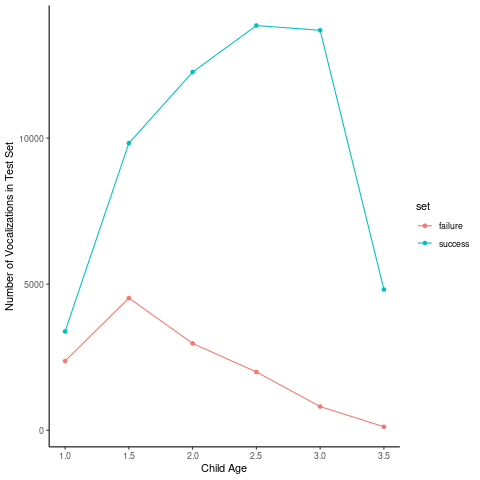

time: 258 ms (started: 2023-02-28 16:48:36 -08:00)


In [23]:
%%R
ggplot(successes_and_failures_per_time) + geom_line(aes(x = age, y=bert_token_id, color=set)) + geom_point(aes(x = age, y=bert_token_id, color=set)
) + xlab('Child Age') + ylab('Number of Vocalizations in Test Set') + theme_classic()

# Analysis 1: Is the child's vocalization intelligible? 

## ROC for Whether a Word Was Found

In [24]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 3353096  741588
time: 2.26 s (started: 2023-02-28 16:48:36 -08:00)


In [25]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "GPT2+CHILDES+OneUtt+Tags"              
 [2] "GPT2+CHILDES+Bidirectional+Tags"       
 [3] "GPT2+CHILDES+Preceding+Tags"           
 [4] "GPT2+CHILDES+OneUtt"                   
 [5] "GPT2+CHILDES+Bidirectional"            
 [6] "GPT2+CHILDES+Preceding"                
 [7] "BERT+CHILDES+OneUtt+Tags"              
 [8] "BERT+CHILDES+Bidirectional+Tags"       
 [9] "BERT+CHILDES+Preceding+Tags"           
[10] "BERT+CHILDES+OneUtt"                   
[11] "BERT+CHILDES+Bidirectional"            
[12] "BERT+CHILDES+Preceding"                
[13] "BERT+YoungerCHILDES+OneUtt+Tags"       
[14] "BERT+YoungerCHILDES+Bidirectional+Tags"
[15] "BERT+YoungerCHILDES+OneUtt"            
[16] "BERT+YoungerCHILDES+Bidirectional"     
[17] "BERT+OlderCHILDES+OneUtt+Tags"         
[18] "BERT+OlderCHILDES+Bidirectional+Tags"  
[19] "BERT+OlderCHILDES+OneUtt"              
[20] "BERT+OlderCHILDES+Bidirectional"       
[21] "BERT+Switchboard+OneUtt"               
[22] "BERT+Switchboard+Bidirection

## WFST


In [26]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_wfst = auc(roc1)))}))

scores_across_time_short_wfst = merge(subset(scores_across_time_short, likelihood_type == 'WFST') , auc_by_model)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 50.7 s (started: 2023-02-28 16:48:38 -08:00)


In [27]:
%%R
scores_across_time_short_wfst$model_shortname = gsub('\\+Tags','', scores_across_time_short_wfst$model)

time: 4.87 s (started: 2023-02-28 16:49:29 -08:00)


In [28]:
%%R
# get rid of tags in the model shortname
scores_across_time_overview_set = filter_model_subset(scores_across_time_short_wfst, overview_set)
# we can do this because for each model with tags, there is no model without tags in the analysis set
scores_across_time_overview_set$model_shortname_with_wfst_auc = paste0(scores_across_time_overview_set$model_shortname,' (AUC = ',round(scores_across_time_overview_set$auc_wfst, 3),')')

time: 2.98 s (started: 2023-02-28 16:49:34 -08:00)


In [29]:
%%R
unique(scores_across_time_overview_set$model_shortname)
# scores_across_time does not have tags in the model name

 [1] "BERT+AdultWritten+Bidirectional" "BERT+AdultWritten+OneUtt"       
 [3] "BERT+CHILDES+Bidirectional"      "BERT+CHILDES+OneUtt"            
 [5] "BERT+CHILDES+Preceding"          "BERT+Switchboard+Bidirectional" 
 [7] "BERT+Switchboard+OneUtt"         "GPT2+CHILDES+OneUtt"            
 [9] "GPT2+CHILDES+Preceding"          "Trigram+CHILDES"                
[11] "Trigram+CHILDES+OneUtt"          "UniformPrior"                   
[13] "Unigram+CHILDES"                
time: 41.1 ms (started: 2023-02-28 16:49:37 -08:00)


In [30]:
%%R 
# get the scores associated with each model + a  
names_per_model = aggregate(model_shortname_with_wfst_auc ~ model_shortname, scores_across_time_overview_set, unique)
scores_per_model_wfst = aggregate(auc_wfst ~ model_shortname,scores_across_time_overview_set, unique)
scores_per_model_wfst = merge(names_per_model, scores_per_model_wfst)
scores_per_model_wfst = scores_per_model_wfst[order(scores_per_model_wfst$auc_wfst, decreasing=T),]
print(scores_per_model_wfst)

scores_across_time_overview_set$model_shortname_with_wfst_auc = factor(as.character(scores_across_time_overview_set$model_shortname_with_wfst_auc), levels = as.character(scores_per_model_wfst$model_shortname_with_wfst_auc))

                   model_shortname
3       BERT+CHILDES+Bidirectional
5           BERT+CHILDES+Preceding
6   BERT+Switchboard+Bidirectional
1  BERT+AdultWritten+Bidirectional
4              BERT+CHILDES+OneUtt
7          BERT+Switchboard+OneUtt
9           GPT2+CHILDES+Preceding
2         BERT+AdultWritten+OneUtt
11          Trigram+CHILDES+OneUtt
8              GPT2+CHILDES+OneUtt
13                 Unigram+CHILDES
10                 Trigram+CHILDES
12                    UniformPrior
                   model_shortname_with_wfst_auc  auc_wfst
3       BERT+CHILDES+Bidirectional (AUC = 0.932) 0.9323031
5           BERT+CHILDES+Preceding (AUC = 0.914) 0.9141799
6   BERT+Switchboard+Bidirectional (AUC = 0.911) 0.9106882
1  BERT+AdultWritten+Bidirectional (AUC = 0.896) 0.8962430
4              BERT+CHILDES+OneUtt (AUC = 0.885) 0.8852089
7          BERT+Switchboard+OneUtt (AUC = 0.873) 0.8728506
9           GPT2+CHILDES+Preceding (AUC = 0.848) 0.8475497
2         BERT+AdultWritten+OneUtt (AU

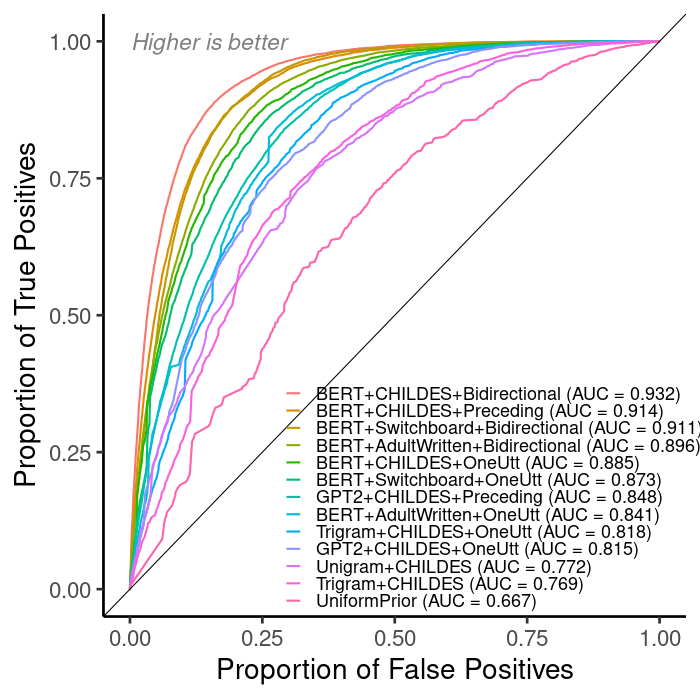

time: 4.35 s (started: 2023-02-28 16:49:40 -08:00)


In [31]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .21),
legend.background = element_blank(), legend.title = element_blank(), legend.text=element_text(size=18)) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('../../output/figures/roc_wfst.pdf', height=10, width=10)    

### Set Color Standards for All Plots

In [32]:
%%R
g <- ggplot_build(p1)
colors_for_13_plots = unique(g$data[[1]]$colour)
#reorder = c(1,3,2,4,5,6,7,8)
#colors_for_8_plots = colors_for_8_plots[reorder]
print(colors_for_13_plots)

 [1] "#F8766D" "#E18A00" "#BE9C00" "#8CAB00" "#24B700" "#00BE70" "#00C1AB"
 [8] "#00BBDA" "#00ACFC" "#8B93FF" "#D575FE" "#F962DD" "#FF65AC"
time: 1.85 s (started: 2023-02-28 16:49:45 -08:00)


In [33]:
%%R
models_for_13_plots = scores_per_model_wfst$model_shortname
shapes_for_13_plots = c(0:12)

time: 7.41 ms (started: 2023-02-28 16:49:46 -08:00)


## Levenshtein Distance

In [34]:
%%R
auc_by_model_lev = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_levdist = auc(roc1)))}))

scores_across_time_short_lev = merge(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance') , auc_by_model_lev)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 49.1 s (started: 2023-02-28 16:49:46 -08:00)


In [35]:
%%R
# get rid of tags in the model shortname
scores_across_time_short_lev = filter_model_subset(scores_across_time_short_lev, overview_set)
scores_across_time_short_lev$model_shortname = gsub('\\+Tags','', scores_across_time_short_lev$model)
# we can do this because for each model with tags, there is no model without tags in the analysis set
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model_shortname,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 3.4 s (started: 2023-02-28 16:50:36 -08:00)


In [36]:
%%R
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model_shortname,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 2.77 s (started: 2023-02-28 16:50:39 -08:00)


In [37]:
%%R
# sort the levels by the scores
names_per_model = aggregate(model_with_levdist_auc ~ model_shortname, scores_across_time_short_lev, unique)
scores_per_model_lev = aggregate(auc_levdist ~ model_shortname, scores_across_time_short_lev, unique)
scores_per_model_lev = merge(names_per_model, scores_per_model_lev)
scores_per_model_lev = scores_per_model_lev[order(scores_per_model_lev$auc_levdist, decreasing=T),]
print(scores_per_model_lev)
scores_across_time_short_lev$model_with_levdist_auc = factor(as.character(scores_across_time_short_lev$model_with_levdist_auc), 
                                                             levels = as.character(scores_per_model_lev$model_with_levdist_auc))



scores_per_model_lev$model_shortname = factor(scores_per_model_lev$model_shortname, levels = as.character(scores_per_model_lev$model_shortname))
scores_across_time_short_lev$model_shortname = factor(scores_across_time_short_lev$model_shortname, levels = as.character(scores_per_model_lev$model_shortname))



                   model_shortname
3       BERT+CHILDES+Bidirectional
5           BERT+CHILDES+Preceding
6   BERT+Switchboard+Bidirectional
1  BERT+AdultWritten+Bidirectional
4              BERT+CHILDES+OneUtt
7          BERT+Switchboard+OneUtt
9           GPT2+CHILDES+Preceding
2         BERT+AdultWritten+OneUtt
11          Trigram+CHILDES+OneUtt
8              GPT2+CHILDES+OneUtt
10                 Trigram+CHILDES
13                 Unigram+CHILDES
12                    UniformPrior
                          model_with_levdist_auc auc_levdist
3       BERT+CHILDES+Bidirectional (AUC = 0.892)   0.8924779
5           BERT+CHILDES+Preceding (AUC = 0.865)   0.8653723
6   BERT+Switchboard+Bidirectional (AUC = 0.859)   0.8587607
1  BERT+AdultWritten+Bidirectional (AUC = 0.845)   0.8450815
4              BERT+CHILDES+OneUtt (AUC = 0.823)   0.8233119
7          BERT+Switchboard+OneUtt (AUC = 0.805)   0.8051918
9           GPT2+CHILDES+Preceding (AUC = 0.787)   0.7870064
2         BERT+AdultWr

In [38]:
%%R
levels(scores_per_model_lev$model_shortname) # this is the one that has to be re-ordered

 [1] "BERT+CHILDES+Bidirectional"      "BERT+CHILDES+Preceding"         
 [3] "BERT+Switchboard+Bidirectional"  "BERT+AdultWritten+Bidirectional"
 [5] "BERT+CHILDES+OneUtt"             "BERT+Switchboard+OneUtt"        
 [7] "GPT2+CHILDES+Preceding"          "BERT+AdultWritten+OneUtt"       
 [9] "Trigram+CHILDES+OneUtt"          "GPT2+CHILDES+OneUtt"            
[11] "Trigram+CHILDES"                 "Unigram+CHILDES"                
[13] "UniformPrior"                   
time: 27.3 ms (started: 2023-02-28 16:50:45 -08:00)


In [39]:
%%R
levels(scores_across_time_short_lev$model_shortname)

 [1] "BERT+CHILDES+Bidirectional"      "BERT+CHILDES+Preceding"         
 [3] "BERT+Switchboard+Bidirectional"  "BERT+AdultWritten+Bidirectional"
 [5] "BERT+CHILDES+OneUtt"             "BERT+Switchboard+OneUtt"        
 [7] "GPT2+CHILDES+Preceding"          "BERT+AdultWritten+OneUtt"       
 [9] "Trigram+CHILDES+OneUtt"          "GPT2+CHILDES+OneUtt"            
[11] "Trigram+CHILDES"                 "Unigram+CHILDES"                
[13] "UniformPrior"                   
time: 26.9 ms (started: 2023-02-28 16:50:45 -08:00)


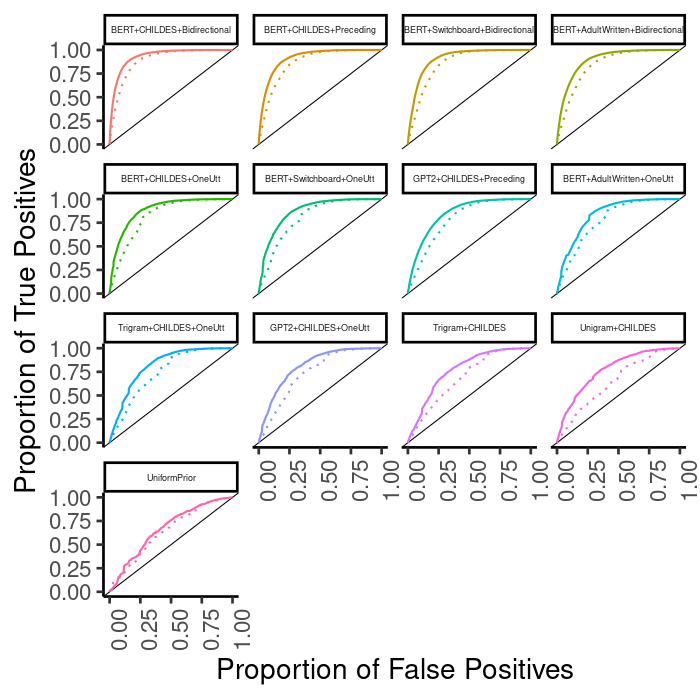

time: 11 s (started: 2023-03-01 09:09:58 -08:00)


In [184]:
%%R -h 700 -w 700
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname), linetype = 'dashed'
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0, linetype="dotted") + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position="none", axis.text.x = element_text(angle = 90, hjust=1)
)  + geom_abline(intercept=0, slope=1
) + facet_wrap(~as.factor(model_shortname)) + geom_roc(data=filter_model_subset(scores_across_time_short_wfst,
overview_set), aes(d=set_binarized, 
m=posterior_entropy, color=model_shortname), n.cuts=0) + theme(strip.text.x = element_text(size = 9))
ggsave('../../output/figures/roc_levdist.pdf', height=10, width=10)   + scale_color_manual(
        values=colors_for_13_plots)  
print(p1)

## Visualization of Successes and Failures

In [41]:
%%R
index_cols = c('bert_token_id', 'set')
selected_cols = c('posterior_entropy', 'posterior_probability', 'posterior_rank', 'prior_entropy', 'prior_probability', 'prior_rank')
best_model = subset(scores_across_time_short, model == "BERT+CHILDES+Bidirectional+Tags" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(best_model) = c(index_cols, paste0('bert_', selected_cols))
base_model = subset(scores_across_time_short, model == "UniformPrior" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(base_model) = c(index_cols, paste0('uniform_', selected_cols))
model_scores_merged = merge(best_model, base_model)

time: 1.2 s (started: 2023-02-28 16:50:55 -08:00)


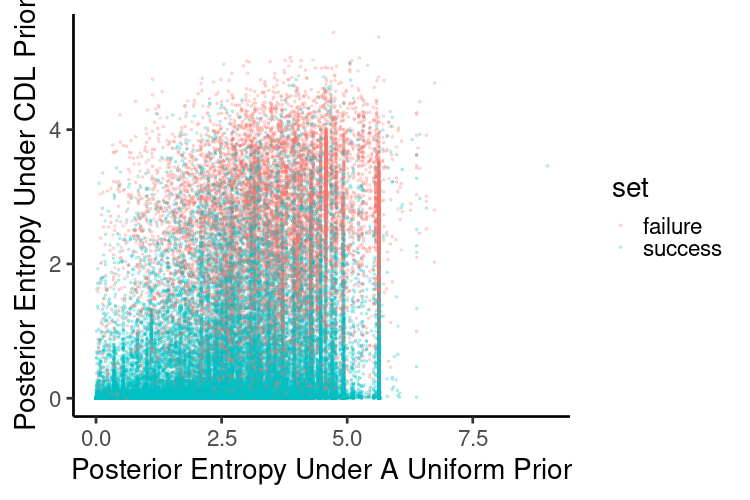

time: 1.12 s (started: 2023-02-28 16:50:56 -08:00)


In [42]:
%%R -w 750 -h 500 
ggplot(model_scores_merged) + geom_point(aes(x=uniform_posterior_entropy, y=bert_posterior_entropy, color=set), alpha=.25, size=1
) + theme_classic(base_size=28) + xlab('Posterior Entropy Under A Uniform Prior') + ylab('Posterior Entropy Under CDL Prior')

## Statistical Tests for Difference in ROC curves

### Pairwise comparison of WFST ROC curves

In [43]:
%%R

models = unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model)
models[1]
roc_tests = mat.or.vec(length(models), length(models))

time: 412 ms (started: 2023-02-28 16:50:57 -08:00)


In [44]:
%%R
test = subset(scores_across_time_short, model == "BERT+Switchboard+Bidirectional" & likelihood_type == 'WFST')
nrow(test)

[1] 70598
time: 170 ms (started: 2023-02-28 16:50:58 -08:00)


In [45]:
%%R
#precompute ROCs
rocs = list()
for (model_name in overview_set){
    print(model_name)
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

[1] "BERT+CHILDES+Bidirectional+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+AdultWritten+Bidirectional"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+CHILDES+OneUtt+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+AdultWritten+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+Switchboard+Bidirectional"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+Switchboard+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "Unigram+CHILDES"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "UniformPrior"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+CHILDES+Preceding+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "Trigram+CHILDES"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "Trigram+CHILDES+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "GPT2+CHILDES+Preceding+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "GPT2+CHILDES+OneUtt+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



time: 3.84 s (started: 2023-02-28 16:50:58 -08:00)


In [46]:
%%R

roc_ps = mat.or.vec(length(overview_set), length(overview_set))
roc_stats = mat.or.vec(length(overview_set), length(overview_set))



for (i in c(1:length(overview_set))){
    for (j in c(1:i)){
        roc1 = rocs[[overview_set[i]]]
        roc2 = rocs[[overview_set[j]]]
        rtest = roc.test(roc1, roc2, method="delong")
        roc_ps[i,j] = round(rtest$p.value, 3)        
        roc_stats [i,j] = abs(round(rtest$statistic, 3))        
    }
}    


roc_ps = data.frame(roc_ps)
names(roc_ps) = overview_set
colnames(roc_ps) = overview_set


roc_stats = data.frame(roc_stats)
names(roc_stats) = overview_set
colnames(roc_stats) = overview_set

time: 1.74 s (started: 2023-02-28 16:51:02 -08:00)


In [47]:
%%R
roc_stats

   BERT+CHILDES+Bidirectional+Tags BERT+AdultWritten+Bidirectional
1                            0.000                           0.000
2                           34.132                           0.000
3                           42.392                           9.332
4                           59.120                          38.813
5                           24.564                          14.584
6                           45.302                          18.657
7                           68.570                          50.347
8                           99.688                          82.547
9                           26.793                          16.623
10                          83.373                          66.974
11                          71.702                          50.278
12                          55.936                          31.587
13                          68.851                          49.794
   BERT+CHILDES+OneUtt+Tags BERT+AdultWritten+OneUtt
1        

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [48]:
%%R
roc_ps

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


   BERT+CHILDES+Bidirectional+Tags BERT+AdultWritten+Bidirectional
1                                1                               0
2                                0                               1
3                                0                               0
4                                0                               0
5                                0                               0
6                                0                               0
7                                0                               0
8                                0                               0
9                                0                               0
10                               0                               0
11                               0                               0
12                               0                               0
13                               0                               0
   BERT+CHILDES+OneUtt+Tags BERT+AdultWritten+OneUtt
1        

In [49]:
%%R
roc_ps[upper.tri(roc_ps, diag=T)] = NA

time: 6.46 ms (started: 2023-02-28 16:51:04 -08:00)


In [50]:
%%R
roc_ps

   BERT+CHILDES+Bidirectional+Tags BERT+AdultWritten+Bidirectional
1                               NA                              NA
2                                0                              NA
3                                0                               0
4                                0                               0
5                                0                               0
6                                0                               0
7                                0                               0
8                                0                               0
9                                0                               0
10                               0                               0
11                               0                               0
12                               0                               0
13                               0                               0
   BERT+CHILDES+OneUtt+Tags BERT+AdultWritten+OneUtt
1        

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [51]:
%%R
# pull out the pairs that 
model_names = names(roc_ps)
for (i in c(1:length(model_names))){    
    for (j in c(1:length(model_names))){
        if (!is.na(roc_ps[i,j])){
            if (roc_ps[i,j] > .05){
                print(paste(model_names[i], '-', model_names[j], roc_ps[i,j], roc_stats[i,j]))
            }
        }
    }
}


[1] "Trigram+CHILDES - Unigram+CHILDES 0.44 0.772"
[1] "GPT2+CHILDES+OneUtt+Tags - Trigram+CHILDES+OneUtt 0.076 1.773"
time: 24.2 ms (started: 2023-02-28 16:51:04 -08:00)


### Paired Comparison of Likelihoods Within Model

In [52]:
%%R
#precompute ROCs
levdist_rocs = list()
for (model_name in overview_set){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    levdist_rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 3.66 s (started: 2023-02-28 16:51:04 -08:00)


In [189]:
%%R
paired_comparison =  do.call('rbind', lapply(overview_set, function(model_name){    
    roc1 = rocs[[model_name]]
    roc2 = levdist_rocs[[model_name]]
    rtest = roc.test(roc1, roc2, method="delong", alternative = 'greater')    

    prob = round(rtest$p.value, 3)        
    stat = abs(round(rtest$statistic, 3))    
    return(data.frame(model_name, prob, stat))        
}))

paired_comparison

                         model_name prob   stat
D   BERT+CHILDES+Bidirectional+Tags    0 23.733
D1  BERT+AdultWritten+Bidirectional    0 24.636
D2         BERT+CHILDES+OneUtt+Tags    0 28.004
D3         BERT+AdultWritten+OneUtt    0 23.475
D4   BERT+Switchboard+Bidirectional    0 27.462
D5          BERT+Switchboard+OneUtt    0 28.905
D6                  Unigram+CHILDES    0 38.021
D7                     UniformPrior    0  7.481
D8      BERT+CHILDES+Preceding+Tags    0 25.868
D9                  Trigram+CHILDES    0 26.181
D10          Trigram+CHILDES+OneUtt    0 27.023
D11     GPT2+CHILDES+Preceding+Tags    0 24.424
D12        GPT2+CHILDES+OneUtt+Tags    0 26.809
time: 396 ms (started: 2023-03-01 10:14:19 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [54]:
%%R
print(auc(rocs[['UniformPrior']]))
print(auc(levdist_rocs[['UniformPrior']]))

Area under the curve: 0.6674
Area under the curve: 0.6408
time: 15.7 ms (started: 2023-02-28 16:51:08 -08:00)


In [55]:
%%R
roc.test(rocs[['UniformPrior']], levdist_rocs[['UniformPrior']], method="delong") 


	DeLong's test for two ROC curves

data:  rocs[["UniformPrior"]] and levdist_rocs[["UniformPrior"]]
D = 7.4812, df = 141037, p-value = 7.407e-14
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.6674332   0.6408311 

time: 52.8 ms (started: 2023-02-28 16:51:08 -08:00)


# Analysis 2: Do the models find the same words as adults?

## Prior and Posterior Table

In [56]:
%%R
unique(successes_across_time$likelihood_type)

[1] "Levenshtein Distance" "WFST"                
time: 86.2 ms (started: 2023-02-28 16:51:08 -08:00)


### WFST

In [57]:
%%R
# note that we don't need to separate the prior computations by the likelihood type-- it's the prior!

prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean(-1 * log(x, base = 2))})
prior_probs = merge(prior_probs, posterior_probs)
    

subset(prior_probs, model %in% overview_set)

                             model prior_probability posterior_probability
1  BERT+AdultWritten+Bidirectional          4.764589             1.1074183
2         BERT+AdultWritten+OneUtt          7.161268             1.9037748
5  BERT+CHILDES+Bidirectional+Tags          2.781817             0.5708678
7         BERT+CHILDES+OneUtt+Tags          5.020420             1.1816452
9      BERT+CHILDES+Preceding+Tags          3.555210             0.7715489
14  BERT+Switchboard+Bidirectional          3.410698             0.7393017
15         BERT+Switchboard+OneUtt          6.332444             1.5961400
23        GPT2+CHILDES+OneUtt+Tags          7.876814             2.6029766
25     GPT2+CHILDES+Preceding+Tags          6.448716             2.0053017
26                 Trigram+CHILDES          7.818443             2.5409173
27          Trigram+CHILDES+OneUtt          8.039081             1.9309137
28                    UniformPrior         12.965243             4.1313128
29                 Unigra

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [58]:
%%R
posterior_probs_sd = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(posterior_probs_sd) = c('model', 'posterior_probability_sem')


prior_probs_sem = aggregate(prior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(prior_probs_sem) = c('model', 'prior_probability_sem')

prior_probs = merge(merge(prior_probs, posterior_probs_sd), prior_probs_sem)
prior_probs = prior_probs[order(prior_probs$prior_probability),]
prior_probs$prior_low = prior_probs$prior_probability - prior_probs$prior_probability_sem
prior_probs$prior_high = prior_probs$prior_probability + prior_probs$prior_probability_sem
prior_probs$posterior_low = prior_probs$posterior_probability - prior_probs$posterior_probability_sem
prior_probs$posterior_high = prior_probs$posterior_probability + prior_probs$posterior_probability_sem
prior_probs


                                    model prior_probability
17 BERT+YoungerCHILDES+Bidirectional+Tags          2.779443
5         BERT+CHILDES+Bidirectional+Tags          2.781817
11   BERT+OlderCHILDES+Bidirectional+Tags          2.813085
16      BERT+YoungerCHILDES+Bidirectional          2.820765
4              BERT+CHILDES+Bidirectional          2.855110
10        BERT+OlderCHILDES+Bidirectional          2.903789
14         BERT+Switchboard+Bidirectional          3.410698
9             BERT+CHILDES+Preceding+Tags          3.555210
8                  BERT+CHILDES+Preceding          3.629521
1         BERT+AdultWritten+Bidirectional          4.764589
7                BERT+CHILDES+OneUtt+Tags          5.020420
13          BERT+OlderCHILDES+OneUtt+Tags          5.025841
3             BERT+AdultWritten+Preceding          5.109277
6                     BERT+CHILDES+OneUtt          5.148332
12               BERT+OlderCHILDES+OneUtt          5.182170
18             BERT+YoungerCHILDES+OneUt

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():



21  6.424381   6.473240     1.9874290      2.0233432
2   7.137628   7.184907     1.8877376      1.9198120
26  7.800914   7.835973     2.5236181      2.5582165
23  7.850281   7.903347     2.5813046      2.6246486
22  7.924108   7.978876     2.5867942      2.6314300
27  8.016700   8.061463     1.9151986      1.9466287
29  8.724595   8.751778     2.3468427      2.3764287
28 12.965243  12.965243     4.1143775      4.1482481
time: 2.15 s (started: 2023-02-28 16:51:11 -08:00)


In [59]:
%%R
# bootstrap it!
library(boot)

fc <- function(x,i ){
	return(mean(x[i]))
}

x = rnorm(1000)
print(x[1:10])
boot.ci(boot(x, fc, R=1000), type="basic")$basic[,4:5]

# get the 95% ci

 [1] -0.18531560  0.33909473 -0.88688445 -0.14798683  0.14283498  1.20595230
 [7] -0.21039890  0.19589192  0.07508564 -1.40973444
[1] -0.08402987  0.04137715
time: 142 ms (started: 2023-02-28 16:51:13 -08:00)


In [60]:
%%R
library('parallel')
fc <- function(x,i ){
	return(mean(x[i]))
}

wfst_df = subset(successes_across_time, likelihood_type == 'WFST')
df_split = split(wfst_df, wfst_df$model) 
results = do.call('rbind', mclapply(df_split, function(df){
    x = -1 * log(df$prior_probability, base = 2)
    ci = boot.ci(boot(x, fc, R=10), type="basic")$basic
    return(data.frame(model = unique(df$model), low=ci[4], high=ci[5]))
}, mc.cores=24))



time: 31.4 s (started: 2023-02-28 16:51:13 -08:00)


In [61]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'likelihood_type', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'likelihood_type', 'mean_prior_rank')

prior_top1 = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){prior_percenttop1 = mean(x ==  0)})
names(prior_top1) = c('model', 'likelihood_type', 'prior_percenttop1')

posterior_median_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){median_posterior_rank = median(x)+1})
names(posterior_median_rankings) = c('model', 'likelihood_type', 'median_posterior_rank')
# 0-indexed coming from Python, so incrementing by one


prior_median_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){median_prior_rank = median(x)+1})
names(prior_median_rankings) = c('model', 'likelihood_type', 'median_prior_rank')
# 0-indexed coming from Pythong, so incrementing by one

top_1 = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){percenttop1 = mean(x ==  0)})
names(top_1) = c('model', 'likelihood_type','percenttop1')


rankings = merge(merge(merge(prior_mean_rankings, posterior_mean_rankings, 
    by=c('model', 'likelihood_type')), top_1), prior_top1)

rankings = merge(rankings, posterior_median_rankings, by=c('model', 'likelihood_type'))
rankings = merge(rankings, prior_median_rankings, by=c('model', 'likelihood_type'))

rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

                             model      likelihood_type mean_prior_rank
9  BERT+CHILDES+Bidirectional+Tags Levenshtein Distance        30.75647
10 BERT+CHILDES+Bidirectional+Tags                 WFST        30.75647
27  BERT+Switchboard+Bidirectional Levenshtein Distance        49.76512
28  BERT+Switchboard+Bidirectional                 WFST        49.76512
17     BERT+CHILDES+Preceding+Tags Levenshtein Distance        61.38935
18     BERT+CHILDES+Preceding+Tags                 WFST        61.38935
1  BERT+AdultWritten+Bidirectional Levenshtein Distance        91.46923
2  BERT+AdultWritten+Bidirectional                 WFST        91.46923
13        BERT+CHILDES+OneUtt+Tags Levenshtein Distance       124.51552
14        BERT+CHILDES+OneUtt+Tags                 WFST       124.51552
57                 Unigram+CHILDES Levenshtein Distance       305.68574
58                 Unigram+CHILDES                 WFST       305.68574
29         BERT+Switchboard+OneUtt Levenshtein Distance       34

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                 3
57                56
58                56
29                 6
30                 6
49                 5
50                 5
3                  8
4                  8
53                 6
54                 6
45                13
46                13
51                33
52                33
55              3999
56              3999
time: 10.4 s (started: 2023-02-28 16:51:44 -08:00)


In [62]:
%%R
for_table = subset(merge(prior_probs, subset(rankings, likelihood_type == 'WFST') , all.x=T), model %in% overview_set, by= 'model')
for_table
for_table$prior_probability = round(for_table$prior_probability, 2)
for_table$posterior_probability = round(for_table$posterior_probability, 2)
for_table$prior_percenttop1 = round(for_table$prior_percenttop1, 2)
for_table$mean_prior_rank = round(for_table$mean_prior_rank, 2)
for_table$mean_posterior_rank = round(for_table$mean_posterior_rank, 2)
for_table$percenttop1 = round(for_table$percenttop1, 2)

time: 11.3 ms (started: 2023-02-28 16:51:55 -08:00)


In [63]:
%%R
nrow(for_table)

[1] 13
time: 16.8 ms (started: 2023-02-28 16:51:55 -08:00)


R[write to console]: Saving 6.67 x 6.67 in image



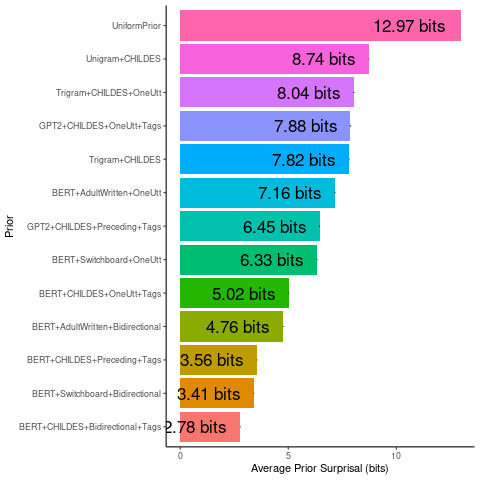

time: 495 ms (started: 2023-02-28 16:51:55 -08:00)


In [64]:
%%R
table_for_ordering = subset(for_table, likelihood_type == 'WFST')
table_for_ordering = table_for_ordering[order(table_for_ordering$prior_probability),]

for_table$model  = factor(for_table$model, levels = table_for_ordering$model)
for_table$prior_probability_bits = paste(for_table$prior_probability, 'bits')

p1 =  ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=prior_probability, fill=model), stat="identity"
) + coord_flip() + ylab('Average Prior Surprisal (bits)') + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=prior_low, ymax = prior_high), width = 0
)+  geom_text(aes(x=model, y=prior_probability, label=prior_probability_bits), hjust=1.2, size=6
) 
print(p1)

ggsave('../../output/figures/prior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



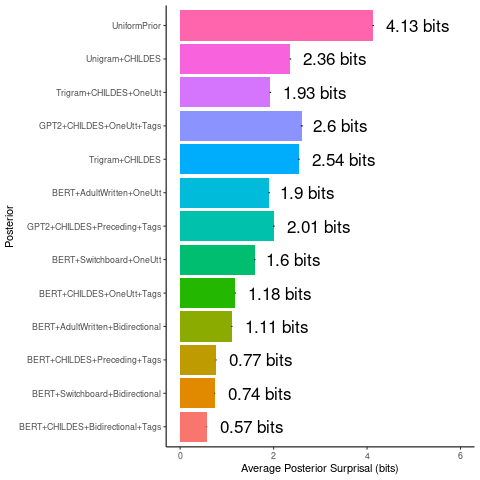

time: 304 ms (started: 2023-02-28 16:51:55 -08:00)


In [65]:
%%R
for_table$posterior_probability_bits = paste(for_table$posterior_probability, 'bits')

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=posterior_probability, fill=model), stat="identity"
)  + ylab('Average Posterior Surprisal (bits)') + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=posterior_low, ymax = posterior_high), width = 0
)+  geom_text(aes(x=model, y=posterior_probability, label=posterior_probability_bits), hjust=-.2, size=6
)  + coord_flip(ylim=c(0, 6))

print(p1)
ggsave('../../output/figures/posterior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



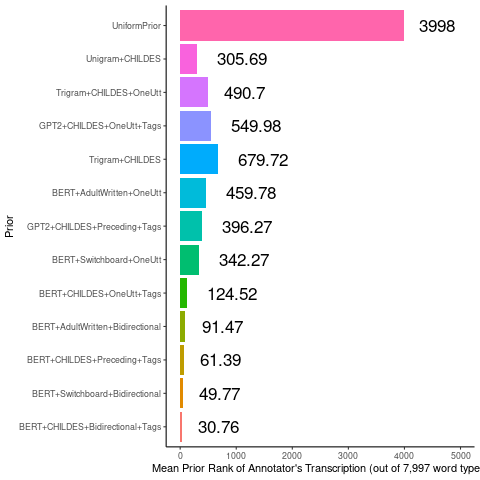

time: 278 ms (started: 2023-02-28 16:51:56 -08:00)


In [66]:
%%R
p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_prior_rank, fill=model), stat="identity"
)  + ylab("Mean Prior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_prior_rank, label=mean_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/prior_rank.pdf')


R[write to console]: Saving 6.67 x 6.67 in image



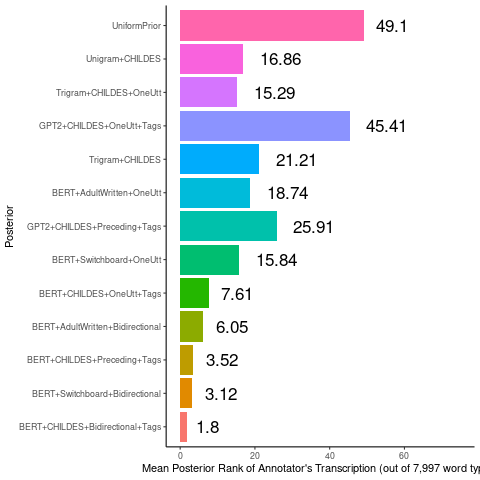

time: 295 ms (started: 2023-02-28 16:51:56 -08:00)


In [67]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model), stat="identity"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_posterior_rank, label=mean_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/posterior_rank.pdf')

### Compare Likelihood Functions

R[write to console]: Saving 6.67 x 6.67 in image



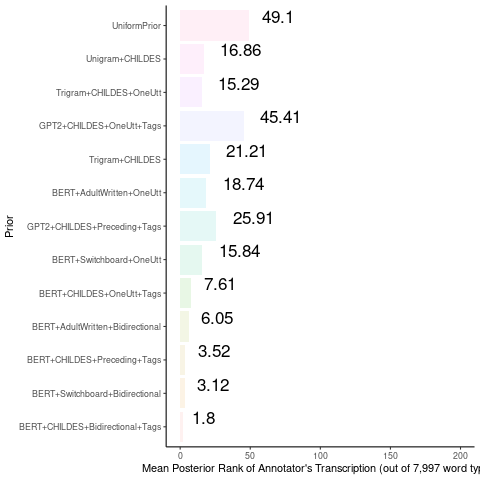

time: 242 ms (started: 2023-02-28 16:51:56 -08:00)


In [68]:
%%R
#library(ggpattern)

p1 = ggplot(for_table) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model, alpha=likelihood_type), stat="identity", position="dodge"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(data=subset(for_table, likelihood_type =='WFST'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=-.2,                                          
position = "dodge") + geom_text(data=subset(for_table, likelihood_type =='Levenshtein Distance'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=1.5,                                          
position = "dodge")  + coord_flip(ylim =c(0, 200)) 
print(p1)
ggsave('../../output/figures/posterior_rank_by_likelihood.pdf')

### Median Ranks

In [69]:
%%R
# aggregate number by rank by mode
number_by_rank_by_model = aggregate(posterior_probability ~ posterior_rank + model,
    subset(successes_across_time, likelihood_type == 'WFST') , length) 
names(number_by_rank_by_model) = c('posterior_rank' , 'model', 'number_items')

number_by_rank_by_model = subset(number_by_rank_by_model, model %in% overview_set)
number_by_rank_by_model$model  = factor(number_by_rank_by_model$model, levels = table_for_ordering$model)


time: 2.47 s (started: 2023-02-28 16:51:56 -08:00)


R[write to console]: Saving 6.67 x 6.67 in image



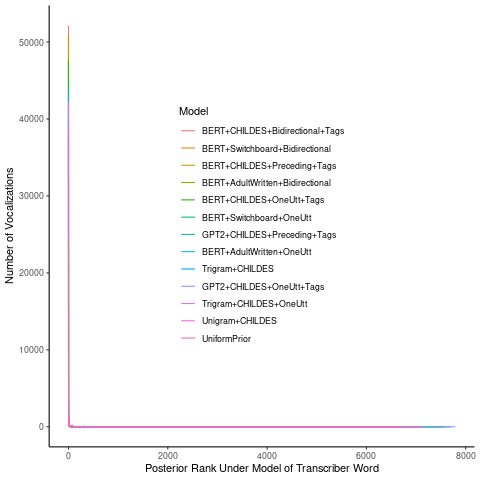

time: 704 ms (started: 2023-02-28 16:51:59 -08:00)


In [70]:
%%R
p1 = ggplot(number_by_rank_by_model) + geom_line(aes(
 x=posterior_rank, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model')
ggsave('../../output/figures/density_posterior_rank_full.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



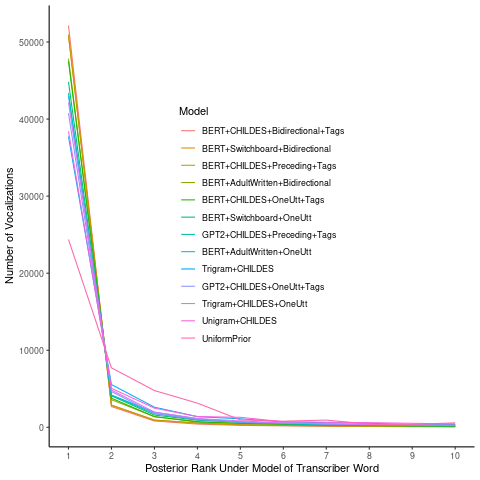

time: 611 ms (started: 2023-02-28 16:52:00 -08:00)


In [71]:
%%R
p1 = ggplot(subset(number_by_rank_by_model,
posterior_rank <= 9)) + geom_line(aes(
 x=posterior_rank+1, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model') + scale_x_continuous(
    breaks = c(1:10), labels = c(1:10))
ggsave('../../output/figures/density_posterior_rank_10.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



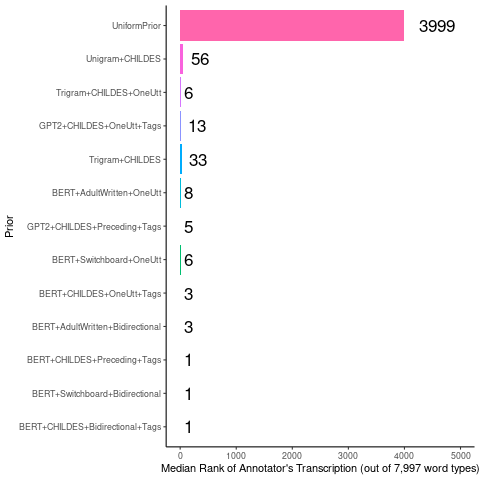

time: 217 ms (started: 2023-02-28 16:52:00 -08:00)


In [72]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_prior_rank, fill=model), stat="identity"
)  + ylab("Median Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_prior_rank, label=median_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/median_prior_rank.pdf')



R[write to console]: Saving 6.67 x 6.67 in image



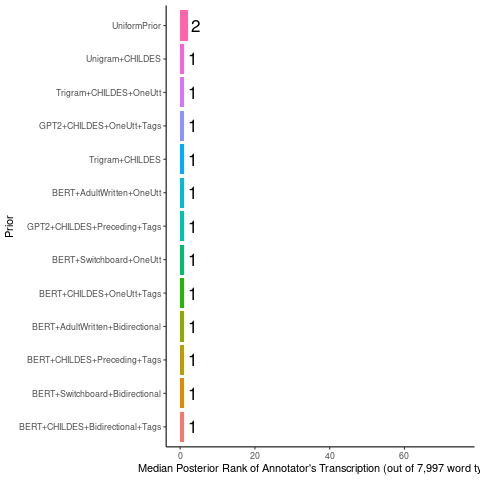

time: 217 ms (started: 2023-02-28 16:52:01 -08:00)


In [73]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_posterior_rank, fill=model), stat="identity"
)  + ylab("Median Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_posterior_rank, label=median_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/median_posterior_rank.pdf')

### Levenshtein Distance (Posteriors Only)

In [74]:
%%R
lev_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean(-1 * log(x, base = 2))})
lev_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x)})
names(lev_rankings) = c('model', 'mean_posterior_rank')
lev_top_1 = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x ==  0)})
names(lev_top_1) = c('model', 'percenttop1')
lev_for_table = subset(merge(merge(lev_probs, lev_rankings, all.x=T), lev_top_1), model %in% overview_set)
lev_for_table[order(lev_for_table$posterior_probability),]

                             model posterior_probability mean_posterior_rank
5  BERT+CHILDES+Bidirectional+Tags              1.032962            5.626341
14  BERT+Switchboard+Bidirectional              1.324101            9.191016
9      BERT+CHILDES+Preceding+Tags              1.406024           11.852245
1  BERT+AdultWritten+Bidirectional              1.846037           18.254757
7         BERT+CHILDES+OneUtt+Tags              2.046490           24.349097
15         BERT+Switchboard+OneUtt              2.627927           44.107175
27          Trigram+CHILDES+OneUtt              2.888315           43.389504
2         BERT+AdultWritten+OneUtt              2.924770           48.795925
25     GPT2+CHILDES+Preceding+Tags              3.169289           66.764893
26                 Trigram+CHILDES              3.728031           57.304902
29                 Unigram+CHILDES              3.909848           50.787224
23        GPT2+CHILDES+OneUtt+Tags              3.993657          104.849184

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [75]:
%%R
wfst_for_table = subset(for_table, likelihood_type == 'WFST')[,c('model', 'prior_probability', 'mean_prior_rank', 'prior_percenttop1', 'posterior_probability','mean_posterior_rank','percenttop1')]
names(wfst_for_table) = c('model', 'prior_surp', 'mean_prior_rank', 'prior_percenttop1', 'wfst_posterior_surp','wfst_mean_posterior_rank', 'wfst_percenttop1')
# wfst_for_table

time: 5.69 ms (started: 2023-02-28 16:52:04 -08:00)


In [76]:
%%R
lev_for_table$posterior_probability = round(lev_for_table$posterior_probability, 2)
lev_for_table$mean_posterior_rank = round(lev_for_table$mean_posterior_rank, 2)
lev_for_table$percent_top_1 = round(lev_for_table$percenttop1, 2)
lev_for_table = lev_for_table[,c('model','posterior_probability','mean_posterior_rank', 'percent_top_1')]
lev_for_table =  lev_for_table[order(lev_for_table$posterior_probability),]
names(lev_for_table) = c('model', 'levdist_posterior_surp', 'levdist_mean_posterior_rank', 'levdist_percenttop1')
lev_for_table

                             model levdist_posterior_surp
5  BERT+CHILDES+Bidirectional+Tags                   1.03
14  BERT+Switchboard+Bidirectional                   1.32
9      BERT+CHILDES+Preceding+Tags                   1.41
1  BERT+AdultWritten+Bidirectional                   1.85
7         BERT+CHILDES+OneUtt+Tags                   2.05
15         BERT+Switchboard+OneUtt                   2.63
27          Trigram+CHILDES+OneUtt                   2.89
2         BERT+AdultWritten+OneUtt                   2.92
25     GPT2+CHILDES+Preceding+Tags                   3.17
26                 Trigram+CHILDES                   3.73
29                 Unigram+CHILDES                   3.91
23        GPT2+CHILDES+OneUtt+Tags                   3.99
28                    UniformPrior                   5.16
   levdist_mean_posterior_rank levdist_percenttop1
5                         5.63                0.84
14                        9.19                0.81
9                        11.85     

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [77]:
%%R
for_table_combined = merge(wfst_for_table, lev_for_table)
for_table_combined = for_table_combined[order(for_table_combined$wfst_posterior_surp),]
write.csv(for_table_combined, '../../output/csv/surprisal_table.csv', row.names=F)

time: 8.5 ms (started: 2023-02-28 16:52:04 -08:00)


In [78]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type BERT+AdultWritten+Bidirectional
2            803            WFST                    9.651294e-02
4            825            WFST                    4.039016e-04
6           1313            WFST                    4.195692e-04
8           1352            WFST                    3.478856e-04
10          1563            WFST                    8.077554e-05
12          1840            WFST                    1.530479e-04
   BERT+AdultWritten+OneUtt BERT+AdultWritten+Preceding
2              3.664199e-04                1.711105e-03
4              1.667180e-04                2.994495e-04
6              1.110267e-04                3.813382e-05
8              1.110267e-04                1.371658e-04
10             7.698668e-06                3.468111e-05
12             2.860038e-04                1.966932e-04
   BERT+CHILDES+Bidirectional BERT+CHILDES+Bidirectional+Tags
2                6.989212e-02                    1.095623e-02
4                5.397139e-04

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [79]:
%%R

model_names = overview_set
print('Model names:')
print(model_names)

for (model_name in model_names){
    successes_across_time_wide[[model_name]] = as.numeric(successes_across_time_wide[[model_name]])
}

successes_across_time_wide_nona = drop_na(successes_across_time_wide)
print(dim(successes_across_time_wide_nona))

[1] "Model names:"
 [1] "BERT+CHILDES+Bidirectional+Tags" "BERT+AdultWritten+Bidirectional"
 [3] "BERT+CHILDES+OneUtt+Tags"        "BERT+AdultWritten+OneUtt"       
 [5] "BERT+Switchboard+Bidirectional"  "BERT+Switchboard+OneUtt"        
 [7] "Unigram+CHILDES"                 "UniformPrior"                   
 [9] "BERT+CHILDES+Preceding+Tags"     "Trigram+CHILDES"                
[11] "Trigram+CHILDES+OneUtt"          "GPT2+CHILDES+Preceding+Tags"    
[13] "GPT2+CHILDES+OneUtt+Tags"       
[1] 57812    31
time: 58.7 ms (started: 2023-02-28 16:52:06 -08:00)


In [80]:
%%R
unique(successes_across_time_wide_nona$likelihood_type)

[1] "WFST"
time: 11.2 ms (started: 2023-02-28 16:52:07 -08:00)


### t-test Pairwise Model Comparison for WFST

In [81]:
%%R
#Pairwise paired t-test between all of the models with WFST only

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rval = t.test(
                successes_across_time_wide_nona[[model_name]], 
                successes_across_time_wide_nona[[comparison_model_name]],
              paired=T)$p.value
            rvs[model_idx, comparison_model_idx] = rval
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                                BERT+CHILDES+Bidirectional+Tags
BERT+CHILDES+Bidirectional+Tags                              NA
BERT+AdultWritten+Bidirectional                               0
BERT+CHILDES+OneUtt+Tags                                      0
BERT+AdultWritten+OneUtt                                      0
BERT+Switchboard+Bidirectional                                0
BERT+Switchboard+OneUtt                                       0
Unigram+CHILDES                                               0
UniformPrior                                                  0
BERT+CHILDES+Preceding+Tags                                   0
Trigram+CHILDES                                               0
Trigram+CHILDES+OneUtt                                        0
GPT2+CHILDES+Preceding+Tags                                   0
GPT2+CHILDES+OneUtt+Tags                                      0
                                BERT+AdultWritten+Bidirectional
BERT+CHILDES+Bidirectional+Tags         

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


             2.491686e-48
GPT2+CHILDES+Preceding+Tags                 0.000000e+00
GPT2+CHILDES+OneUtt+Tags                              NA
time: 536 ms (started: 2023-02-28 16:52:07 -08:00)


### Prior Surprisal Across Ages Plots

In [82]:
%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model', 'likelihood_type','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood_type','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,likelihood_type,prior_surprisal_mean,prior_surprisal_sem
1,1.0,BERT+AdultWritten+Bidirectional,Levenshtein Distance,7.831925,0.072649
2,1.0,BERT+AdultWritten+Bidirectional,WFST,7.831925,0.072649
3,1.0,BERT+AdultWritten+OneUtt,Levenshtein Distance,11.750090,0.085251
4,1.0,BERT+AdultWritten+OneUtt,WFST,11.750090,0.085251
5,1.0,BERT+AdultWritten+Preceding,Levenshtein Distance,8.542658,0.079379
...,...,...,...,...,...
344,3.5,Trigram+CHILDES+OneUtt,WFST,7.689730,0.079226
345,3.5,UniformPrior,Levenshtein Distance,12.965243,0.000000
346,3.5,UniformPrior,WFST,12.965243,0.000000
347,3.5,Unigram+CHILDES,Levenshtein Distance,8.474528,0.046371


time: 8.71 s (started: 2023-02-28 16:52:07 -08:00)


In [83]:
%%R
overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

time: 31.2 ms (started: 2023-02-28 16:52:16 -08:00)


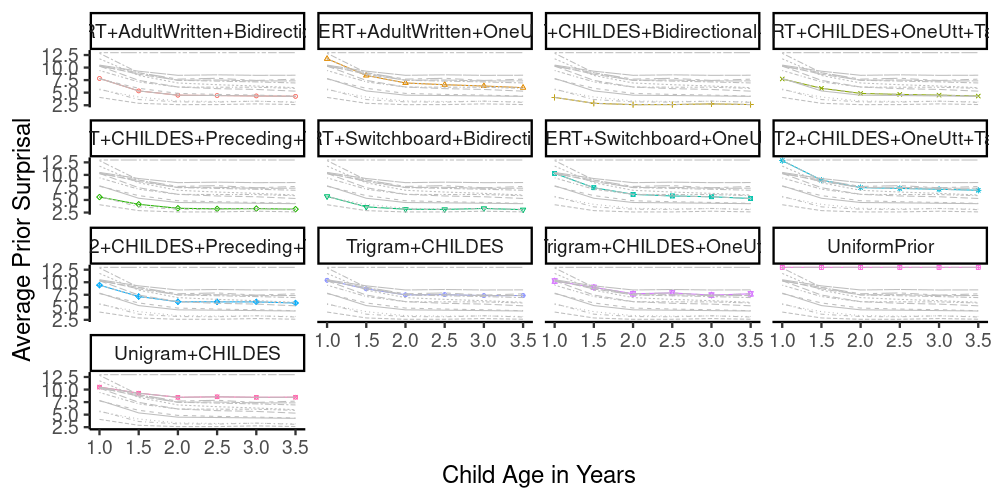

time: 1.06 s (started: 2023-02-28 16:52:16 -08:00)


In [84]:
%%R -w 1000 -h 500
ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none') + scale_shape_manual(values=1:nlevels(as.factor(overview_mean_surprisal_by_age$model))
    ) + scale_color_discrete()

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 

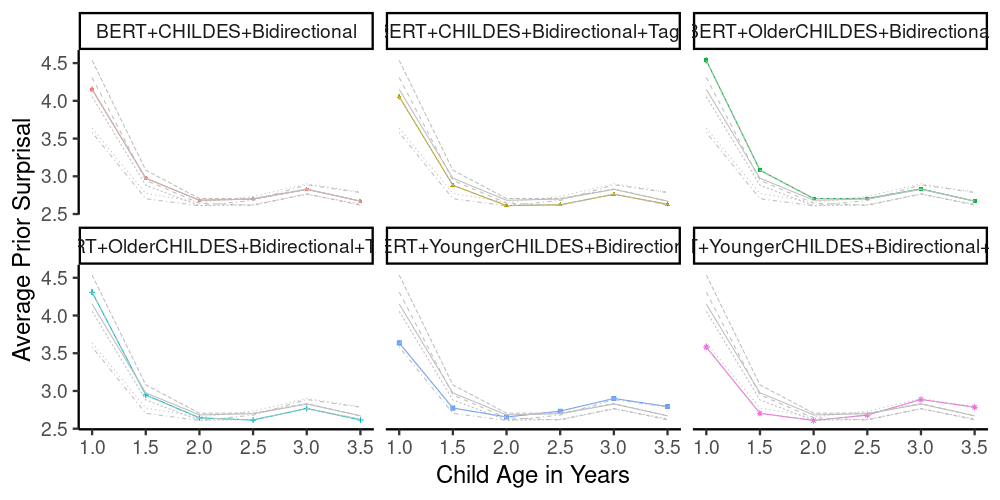

time: 441 ms (started: 2023-02-28 16:52:17 -08:00)


In [85]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')



## Posterior

In [86]:
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
#%R print(mean_surprisal_by_age)

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.0,BERT+AdultWritten+Bidirectional,Levenshtein Distance,5.509844,0.095285
2,1.0,BERT+AdultWritten+Bidirectional,WFST,3.771037,0.083204
3,1.0,BERT+AdultWritten+OneUtt,Levenshtein Distance,8.806447,0.132075
4,1.0,BERT+AdultWritten+OneUtt,WFST,6.515641,0.115163
5,1.0,BERT+AdultWritten+Preceding,Levenshtein Distance,6.041931,0.101973
...,...,...,...,...,...
344,3.5,Trigram+CHILDES+OneUtt,WFST,1.020754,0.035010
345,3.5,UniformPrior,Levenshtein Distance,3.793817,0.049583
346,3.5,UniformPrior,WFST,2.888365,0.040506
347,3.5,Unigram+CHILDES,Levenshtein Distance,2.532025,0.050422


time: 8.45 s (started: 2023-02-28 16:52:17 -08:00)


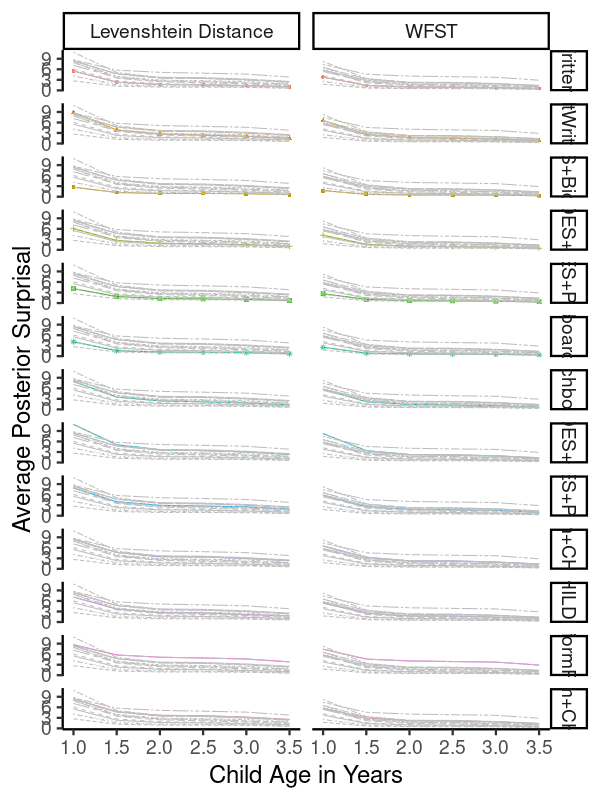

time: 1.2 s (started: 2023-02-28 16:52:26 -08:00)


In [87]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


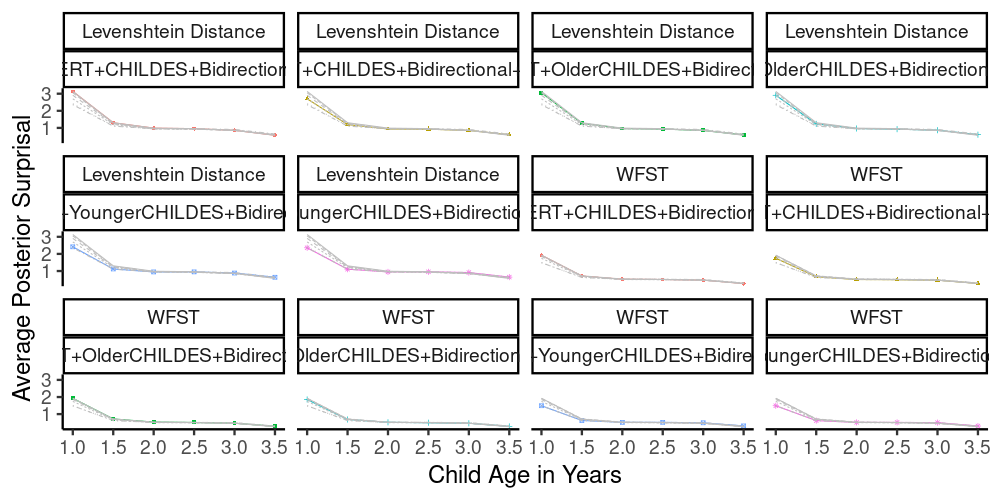

time: 814 ms (started: 2023-02-28 16:52:27 -08:00)


In [88]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [89]:
%%R
unique(as.character(mean_surprisal_by_age$model))

 [1] "BERT+AdultWritten+Bidirectional"       
 [2] "BERT+AdultWritten+OneUtt"              
 [3] "BERT+AdultWritten+Preceding"           
 [4] "BERT+CHILDES+Bidirectional"            
 [5] "BERT+CHILDES+Bidirectional+Tags"       
 [6] "BERT+CHILDES+OneUtt"                   
 [7] "BERT+CHILDES+OneUtt+Tags"              
 [8] "BERT+CHILDES+Preceding"                
 [9] "BERT+CHILDES+Preceding+Tags"           
[10] "BERT+OlderCHILDES+Bidirectional"       
[11] "BERT+OlderCHILDES+Bidirectional+Tags"  
[12] "BERT+OlderCHILDES+OneUtt"              
[13] "BERT+OlderCHILDES+OneUtt+Tags"         
[14] "BERT+Switchboard+Bidirectional"        
[15] "BERT+Switchboard+OneUtt"               
[16] "BERT+YoungerCHILDES+Bidirectional"     
[17] "BERT+YoungerCHILDES+Bidirectional+Tags"
[18] "BERT+YoungerCHILDES+OneUtt"            
[19] "BERT+YoungerCHILDES+OneUtt+Tags"       
[20] "GPT2+CHILDES+Bidirectional"            
[21] "GPT2+CHILDES+Bidirectional+Tags"       
[22] "GPT2+CHILDES+OneUtt"        

In [90]:
%%R
mean_surprisal_by_age$model_shortname = gsub('\\+Tags', '', mean_surprisal_by_age$model)

time: 7.47 ms (started: 2023-02-28 16:52:28 -08:00)


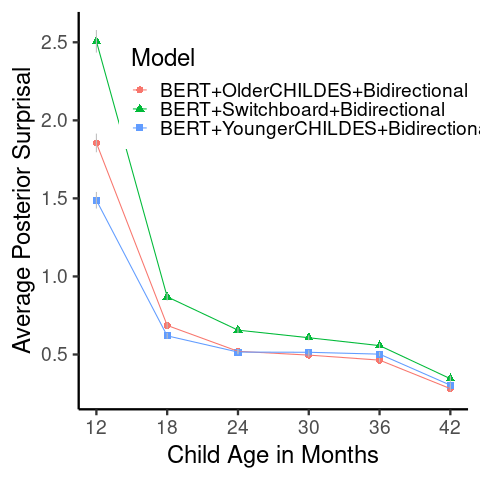

time: 428 ms (started: 2023-03-01 09:36:23 -08:00)


In [188]:
%%R 

selected_models = c('BERT+YoungerCHILDES+Bidirectional+Tags', 'BERT+OlderCHILDES+Bidirectional+Tags',
                   'BERT+Switchboard+Bidirectional')

mean_surprisal_by_age$age_in_months = mean_surprisal_by_age$age * 12

p1 =  ggplot(subset(mean_surprisal_by_age, likelihood == 'WFST' &  model %in% selected_models)
    )  + geom_point(aes(
    x=age_in_months, y=posterior_surprisal_mean, color=model_shortname,
    shape = model_shortname), size=3) + geom_line(aes(x=age_in_months, y=posterior_surprisal_mean, color=model_shortname)
    )  + geom_errorbar(aes(x=age_in_months, ymin=posterior_surprisal_mean - posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + posterior_surprisal_sem), color="gray",  width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Months') + theme(
    legend.position=c(.6, .8))  +  guides(shape = guide_legend(title = "Model"), color = guide_legend(title = "Model")
    ) + scale_x_continuous( breaks = seq(from=6, to=48, by=6), labels= seq(from=6, to=48, by=6))

ggsave('../../output/figures/posterior_surprisal_by_age.pdf', height=6, width=8)
p1


In [92]:
scores_across_time_short.drop_duplicates(subset=['bert_token_id']).set.value_counts()

success    57812
failure    12786
Name: set, dtype: int64

time: 109 ms (started: 2023-02-28 16:52:28 -08:00)


In [106]:
%%R
unique(successes_across_time$model)

 [1] "GPT2+CHILDES+OneUtt+Tags"              
 [2] "GPT2+CHILDES+Bidirectional+Tags"       
 [3] "GPT2+CHILDES+Preceding+Tags"           
 [4] "GPT2+CHILDES+OneUtt"                   
 [5] "GPT2+CHILDES+Bidirectional"            
 [6] "GPT2+CHILDES+Preceding"                
 [7] "BERT+CHILDES+OneUtt+Tags"              
 [8] "BERT+CHILDES+Bidirectional+Tags"       
 [9] "BERT+CHILDES+Preceding+Tags"           
[10] "BERT+CHILDES+OneUtt"                   
[11] "BERT+CHILDES+Bidirectional"            
[12] "BERT+CHILDES+Preceding"                
[13] "BERT+YoungerCHILDES+OneUtt+Tags"       
[14] "BERT+YoungerCHILDES+Bidirectional+Tags"
[15] "BERT+YoungerCHILDES+OneUtt"            
[16] "BERT+YoungerCHILDES+Bidirectional"     
[17] "BERT+OlderCHILDES+OneUtt+Tags"         
[18] "BERT+OlderCHILDES+Bidirectional+Tags"  
[19] "BERT+OlderCHILDES+OneUtt"              
[20] "BERT+OlderCHILDES+Bidirectional"       
[21] "BERT+Switchboard+OneUtt"               
[22] "BERT+Switchboard+Bidirection

In [107]:
%%R
age_test_dataset = subset(successes_across_time, model %in% c('BERT+YoungerCHILDES+Bidirectional+Tags', 'BERT+OlderCHILDES+Bidirectional+Tags'))

time: 3.42 s (started: 2023-02-28 17:00:17 -08:00)


In [108]:
%%R
nrow(age_test_dataset)

[1] 231248
time: 15 ms (started: 2023-02-28 17:00:22 -08:00)


In [109]:
%%R
max(age_test_dataset$posterior_probability)
age_test_dataset$posterior_surprisal = -1 * log(age_test_dataset$posterior_probability, base =2) 

time: 18.7 ms (started: 2023-02-28 17:00:31 -08:00)


In [110]:
%%R
library('lmerTest')

time: 8.86 ms (started: 2023-02-28 17:00:46 -08:00)


In [112]:
%%R
lm1 = lmer(posterior_surprisal ~ age * model + (age * model|token), age_test_dataset)
summary(lm1)

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: posterior_surprisal ~ age * model + (age * model | token)
   Data: age_test_dataset

REML criterion at convergence: 968956.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3004 -0.3328 -0.1732 -0.0481 14.0729 

Random effects:
 Groups   Name                                            Variance Std.Dev.
 token    (Intercept)                                     61.73884 7.8574  
          age                                              9.43313 3.0713  
          modelBERT+YoungerCHILDES+Bidirectional+Tags      0.61831 0.7863  
          age:modelBERT+YoungerCHILDES+Bidirectional+Tags  0.07559 0.2749  
 Residual                                                  3.64727 1.9098  
 Corr             
                  
 -0.96            
 -0.94  0.84      
  0.92 -0.79 -0.99
                  
Number of obs: 231248, groups:  token, 2428

Fixed effects:
                               

### Posterior Probability by Edit Distance

In [98]:
%%R
# have to do some data rotation to handle the fact that each observation needs both a Levenshtein distance and an edit dsitance
levdists = subset(successes_across_time, likelihood_type == "Levenshtein Distance" & model %in% overview_set)
dim(levdists)
wfsts = subset(successes_across_time, likelihood_type == "WFST" & model %in% overview_set)
dim(wfsts)

[1] 751556     16
time: 418 ms (started: 2023-02-28 16:52:28 -08:00)


In [99]:
%%R
unique(as.character(levdists$model))

 [1] "GPT2+CHILDES+OneUtt+Tags"        "GPT2+CHILDES+Preceding+Tags"    
 [3] "BERT+CHILDES+OneUtt+Tags"        "BERT+CHILDES+Bidirectional+Tags"
 [5] "BERT+CHILDES+Preceding+Tags"     "BERT+Switchboard+OneUtt"        
 [7] "BERT+Switchboard+Bidirectional"  "BERT+AdultWritten+OneUtt"       
 [9] "BERT+AdultWritten+Bidirectional" "UniformPrior"                   
[11] "Unigram+CHILDES"                 "Trigram+CHILDES"                
[13] "Trigram+CHILDES+OneUtt"         
time: 39.2 ms (started: 2023-02-28 16:52:29 -08:00)


In [100]:
%%R
wfsts$wfst_distance = wfsts$edit_distance # copy wfst distance into its own column
wfsts$edit_distance = NULL
levdists$wfst_distance = 0 # leave this column unpopulated on levdists

time: 5.64 ms (started: 2023-02-28 16:52:29 -08:00)


In [101]:
%%R
print(dim(wfsts))
print(dim(levdists))

[1] 751556     16
[1] 751556     17
time: 25.8 ms (started: 2023-02-28 16:52:29 -08:00)


In [102]:
%%R
wfsts_merged = merge(wfsts, levdists[,c('bert_token_id','edit_distance')]) # this takes a while

time: 2min 45s (started: 2023-02-28 16:52:29 -08:00)


In [103]:
%%R
levdists[,c('bert_token_id','edit_distance')][1:10,]

     bert_token_id edit_distance
4525       2421846             1
4526       2421847             0
4527       1960712             3
4528       1960713             1
4529        525997             4
4530        525998             0
4531       1680530             1
4532        541940             2
4533         19557             1
4534         19558             0
time: 45.3 ms (started: 2023-02-28 16:55:15 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [113]:
%%R 
ed = rbind.fill(wfsts_merged, levdists) # this takes a while

time: 2min 22s (started: 2023-02-28 17:20:15 -08:00)


In [114]:
%%R
# confirm that edit distances are integers
unique(ed$edit_distance)

[1] 2 5 0 1 3 4 6 7
time: 345 ms (started: 2023-03-01 08:25:22 -08:00)


#### Statistical Test for Surprisal by Edit Distance

In [115]:
%%R
names(ed)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "model_remapped"       
[16] "wfst_distance"         "edit_distance"        
time: 29.3 ms (started: 2023-03-01 08:25:23 -08:00)


In [116]:
%%R
names(ed)
lm1 = lm(posterior_probability ~ edit_distance , ed)
lm2 = lm(posterior_probability ~ edit_distance * model , ed)


print(BIC(lm1))
print(BIC(lm2))

# is a particular model actually lower? 

[1] 7673790
[1] 5200682
time: 19.5 s (started: 2023-03-01 08:25:23 -08:00)


In [117]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal + surprisal_by_edit_distance$mean_posterior_surprisal_sem 
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal - surprisal_by_edit_distance$mean_posterior_surprisal_sem



time: 30.5 s (started: 2023-03-01 08:25:42 -08:00)


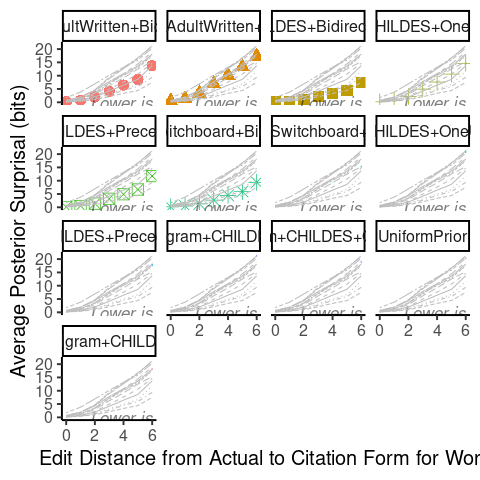

time: 1.03 s (started: 2023-03-01 08:26:13 -08:00)


In [119]:
%%R
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')
print(p1)

#### Levenshtein Distance Plots

In [140]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'Levenshtein Distance')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance_lev = merge(subset(surprisal_by_edit_distance, likelihood_type == 'Levenshtein Distance'), unigram_prior)
surprisal_by_edit_distance_lev$multiplier = 2^( surprisal_by_edit_distance_lev$unigram_prior_prob -
    surprisal_by_edit_distance_lev$mean_posterior_surprisal)

head(surprisal_by_edit_distance_lev, n=10)


   edit_distance                           model      likelihood_type
1              0 BERT+AdultWritten+Bidirectional Levenshtein Distance
2              0        BERT+AdultWritten+OneUtt Levenshtein Distance
3              0 BERT+CHILDES+Bidirectional+Tags Levenshtein Distance
4              0        BERT+CHILDES+OneUtt+Tags Levenshtein Distance
5              0     BERT+CHILDES+Preceding+Tags Levenshtein Distance
6              0  BERT+Switchboard+Bidirectional Levenshtein Distance
7              0         BERT+Switchboard+OneUtt Levenshtein Distance
8              0        GPT2+CHILDES+OneUtt+Tags Levenshtein Distance
9              0     GPT2+CHILDES+Preceding+Tags Levenshtein Distance
10             0                 Trigram+CHILDES Levenshtein Distance
   mean_posterior_surprisal mean_posterior_surprisal_sem      high       low
1                 0.3339371                  0.006629389 0.3405665 0.3273077
2                 0.5515791                  0.009268567 0.5608477 0.5423105

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


           1.492868   1.632966
10           1.492868   1.708681
time: 228 ms (started: 2023-03-01 08:30:32 -08:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



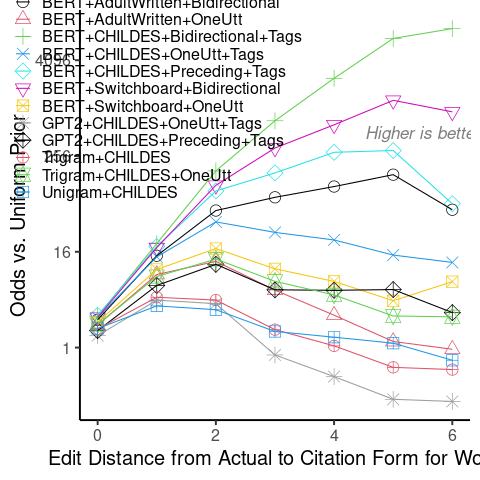

time: 426 ms (started: 2023-03-01 08:30:34 -08:00)


In [141]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance_lev, edit_distance <= 6 & model %in% overview_set 
& likelihood_type =='Levenshtein Distance' & model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=512, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2'
) + scale_shape_manual(values = 1:12) + scale_color_manual(values = 1:12)    
print(p2)

#### WFST Plots

In [208]:
%%R
# make sure it uses the same colors
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)
surprisal_by_edit_distance_for_plot$model_shortname= gsub('\\+Tags','',surprisal_by_edit_distance_for_plot$model)
surprisal_by_edit_distance_for_plot$model_shortname = factor(surprisal_by_edit_distance_for_plot$model_shortname, levels = models_for_13_plots)

time: 19.2 ms (started: 2023-03-01 11:53:31 -08:00)


In [209]:
%%R
models_for_13_plots

 [1] "BERT+CHILDES+Bidirectional"      "BERT+CHILDES+Preceding"         
 [3] "BERT+Switchboard+Bidirectional"  "BERT+AdultWritten+Bidirectional"
 [5] "BERT+CHILDES+OneUtt"             "BERT+Switchboard+OneUtt"        
 [7] "GPT2+CHILDES+Preceding"          "BERT+AdultWritten+OneUtt"       
 [9] "Trigram+CHILDES+OneUtt"          "GPT2+CHILDES+OneUtt"            
[11] "Unigram+CHILDES"                 "Trigram+CHILDES"                
[13] "UniformPrior"                   
time: 34.6 ms (started: 2023-03-01 11:53:33 -08:00)


In [210]:
%%R
unique(as.character(surprisal_by_edit_distance_for_plot$model_shortname))

 [1] "BERT+AdultWritten+Bidirectional" "BERT+AdultWritten+OneUtt"       
 [3] "BERT+CHILDES+Bidirectional"      "BERT+CHILDES+OneUtt"            
 [5] "BERT+CHILDES+Preceding"          "BERT+Switchboard+Bidirectional" 
 [7] "BERT+Switchboard+OneUtt"         "GPT2+CHILDES+OneUtt"            
 [9] "GPT2+CHILDES+Preceding"          "Trigram+CHILDES"                
[11] "Trigram+CHILDES+OneUtt"          "UniformPrior"                   
[13] "Unigram+CHILDES"                
time: 34.8 ms (started: 2023-03-01 11:53:33 -08:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.



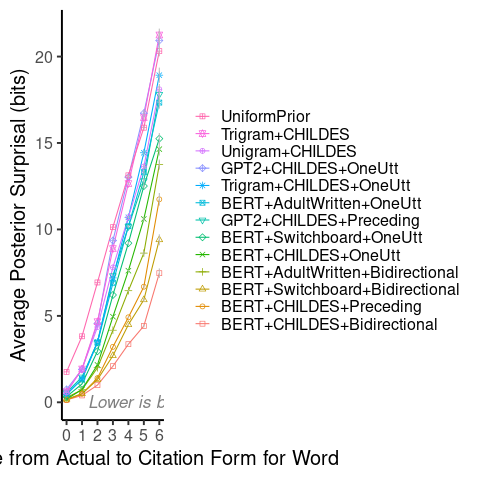

time: 1.42 s (started: 2023-03-01 11:55:36 -08:00)


In [215]:
%%R
p1= ggplot(surprisal_by_edit_distance_for_plot)  + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model_shortname, 
shape=model_shortname)) + theme(legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model_shortname, shape=model_shortname), size=2) + scale_shape_manual(values=1:nlevels(surprisal_by_edit_distance_for_plot$model)) + scale_color_manual(
        values=1:nlevels(surprisal_by_edit_distance_for_plot$model_shortname)) + scale_color_manual(
        values=colors_for_13_plots) + scale_shape_manual(values = shapes_for_13_plots) + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high), color="gray", width=0) + guides(col = guide_legend(reverse = TRUE), shape = guide_legend(reverse = TRUE))


ggsave('../../output/figures/surpsisal_by_edit_distance_wfst.pdf', height=6, width=10)    
print(p1)

### Proportion Agreeing with Annotator Per Age

In [146]:
%%R
names(successes_across_time)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "model_remapped"       
time: 35.1 ms (started: 2023-03-01 08:30:56 -08:00)


In [204]:
%%R
successes_across_time$model_shortname= gsub('\\+Tags','',successes_across_time$model)
successes_across_time$model_shortname = factor(successes_across_time$model_shortname, levels = models_for_13_plots)

time: 10.1 s (started: 2023-03-01 11:42:11 -08:00)


In [205]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model_shortname + age + likelihood_type, successes_across_time, function(x){mean(x == 0)})

time: 2.56 s (started: 2023-03-01 11:42:21 -08:00)


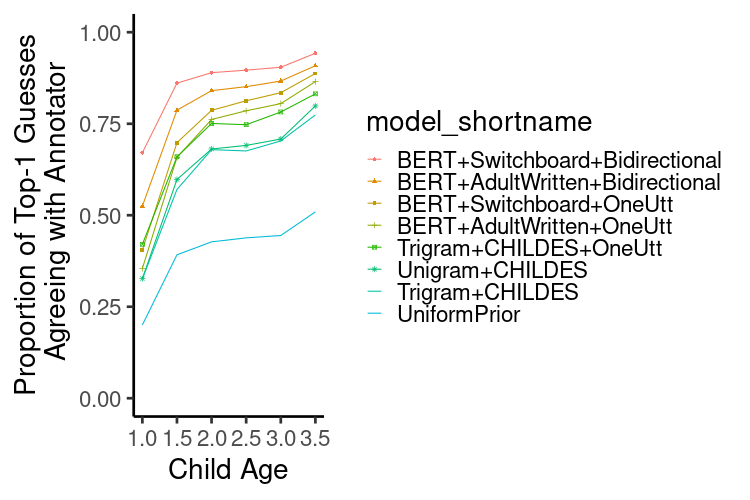

time: 322 ms (started: 2023-03-01 11:42:23 -08:00)


In [206]:
%%R -w 750 -h 500
ggplot(filter_model_subset(subset(proportion_retrieved, likelihood_type == 'WFST'), overview_set)) + geom_line(aes(x=age, y=posterior_rank, color=model_shortname)
) + geom_point(aes(x=age, y=posterior_rank, color=model_shortname, shape=model_shortname)) + coord_cartesian(ylim=c(0,1)) + scale_color_manual(values=colors_for_13_plots) + xlab('Child Age') + ylab(
    'Proportion of Top-1 Guesses\n Agreeing with Annotator') + theme_classic(base_size=28) + theme(legend.background = element_blank()
) 

### Posterior by Edit Distance by Likelihood 

In [149]:
from src.utils import load_splits
all_tokens_phono = load_splits.load_phono()

time: 8.21 s (started: 2023-03-01 08:31:02 -08:00)


In [150]:
all_tokens_phono.columns

Index(['token', 'utterance_id', 'gloss', 'transcript_id', 'utterance_order',
       'target_child_name', 'speaker_code', 'type', 'punct',
       'speaker_code_simple', 'gloss_with_punct', 'token_id', 'seq_utt_id',
       'actual_phonology', 'model_phonology', 'target_child_age',
       'bert_token_id', 'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw_actual',
       'cv_collapsed_actual', 'num_vowels_actual', 'cv_raw_model',
       'cv_collapsed_model', 'num_vowels_model', 'num_vowels', 'in_vocab',
       'success_token', 'yyy_token', 'partition', 'phase', 'year',
       'phase_child_sample', 'phase_child_finetune',
       'phase_child_sample_n=2_type=success_name=Alex',
       'phase_child_sample_n=2_type=success_name=Ethan',
       'phase_child_sample_n=2_type=success_name=Lily',
       'phase_child_sample_n=2_type=success_name=Naima',
       'phase_child_sample_n=2_type=success_name=Violet',
       'phase_child_sa

time: 3.45 ms (started: 2023-03-01 08:31:10 -08:00)


In [151]:
all_tokens_phono['citation_len'] = [len(x) for x in all_tokens_phono.model_phonology_no_dia]
all_tokens_phono['child_len'] = [len(x) for x in all_tokens_phono.actual_phonology_no_dia]
all_tokens_phono['phono_change'] = all_tokens_phono['child_len'] - all_tokens_phono['citation_len']
ipa_tokens = all_tokens_phono.dropna(subset=['actual_phonology_no_dia'])[['bert_token_id','phono_change']]
%R -i ipa_tokens

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


time: 24.8 s (started: 2023-03-01 08:31:59 -08:00)


In [152]:
%%R
ed_with_phono_change = merge(ed, ipa_tokens)

time: 2min 50s (started: 2023-03-01 08:32:23 -08:00)


In [153]:
%%R
names(ed_with_phono_change)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "model_remapped"       
[16] "wfst_distance"         "edit_distance"         "phono_change"         
time: 30.6 ms (started: 2023-03-01 08:35:14 -08:00)


In [154]:
%%R

#need the length of the adult string vs. the child string 

prob_by_edit_distance_likelihood = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, mean)

prob_by_edit_distance_likelihood_sem = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, sem)
names(prob_by_edit_distance_likelihood_sem) = c('likelihood_type', 'phono_change', 'model', 'sem')

prob_by_edit_distance_likelihood = merge(prob_by_edit_distance_likelihood, prob_by_edit_distance_likelihood_sem)
prob_by_edit_distance_likelihood$high = prob_by_edit_distance_likelihood$posterior_probability + prob_by_edit_distance_likelihood$sem
prob_by_edit_distance_likelihood$low = prob_by_edit_distance_likelihood$posterior_probability - prob_by_edit_distance_likelihood$sem


time: 17.8 s (started: 2023-03-01 08:35:14 -08:00)


In [155]:
%%R
prob_by_edit_distance_likelihood$likelihood_type[prob_by_edit_distance_likelihood$likelihood_type ==
    'Levenshtein Distance'] = 'Edit Distance'

time: 4.03 ms (started: 2023-03-01 08:35:32 -08:00)


In [156]:
%%R
prob_by_edit_distance_likelihood$likelihood_type = factor(prob_by_edit_distance_likelihood$likelihood_type, 
levels = c('WFST', 'Edit Distance'))

time: 19.9 ms (started: 2023-03-01 08:35:32 -08:00)


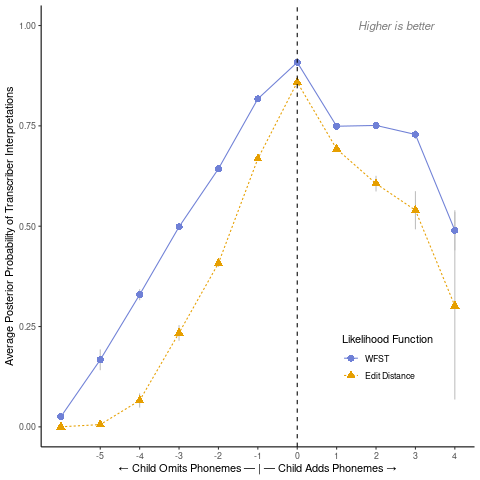

time: 516 ms (started: 2023-03-03 11:10:07 -08:00)


In [223]:
%%R
p1 = ggplot(subset(prob_by_edit_distance_likelihood, model == "BERT+CHILDES+Bidirectional+Tags")) + geom_errorbar(
aes(x=phono_change, ymin = low, ymax=high), color='gray', width=0) + geom_line(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, linetype = likelihood_type )) + geom_point(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, shape=likelihood_type), size=3) + theme_classic() + ylab('Average Posterior Probability of Transcriber Interpretations') + xlab (
    '← Child Omits Phonemes — | — Child Adds Phonemes →') + geom_vline(xintercept=0, linetype='dashed'
) + scale_x_continuous(breaks=c(-5:5), labels = c(-5:5))  + scale_shape_discrete(name = "Likelihood Function") + scale_linetype_discrete(name = "Likelihood Function") + theme(legend.position = c(.8, .2)
) + annotate("text", label="Higher is better", 
    x=2.5, y=1, alpha=.5, size=4, fontface ="italic")  + scale_color_manual(values=c("#6f80d6", "#E69F00"), name = "Likelihood Function")

ggsave("../../output/figures/likelihood_function_by_change.pdf", width = 5, height=5)
print(p1)

# Child-Specific Analyses

In [159]:
all_tokens_phono_short = all_tokens_phono[['bert_token_id','target_child_name']]
%R -i all_tokens_phono_short

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


time: 30.1 s (started: 2023-03-01 08:38:47 -08:00)


In [160]:
%%R
successes_across_time_with_child_label = merge(successes_across_time, all_tokens_phono_short)

time: 58.7 s (started: 2023-03-01 08:39:29 -08:00)


In [161]:
%%R
successes_across_time_with_child_label = subset(successes_across_time_with_child_label, model %in% overview_set)

time: 23 s (started: 2023-03-01 08:40:28 -08:00)


In [162]:
%%R
successes_across_time_with_child_label$model = gsub('\\+Tags','', successes_across_time_with_child_label$model)

time: 3.9 s (started: 2023-03-01 08:40:51 -08:00)


In [163]:
%%R
unique(successes_across_time_with_child_label$model)

 [1] "BERT+Switchboard+OneUtt"         "BERT+AdultWritten+OneUtt"       
 [3] "BERT+CHILDES+Bidirectional"      "BERT+Switchboard+Bidirectional" 
 [5] "BERT+CHILDES+Preceding"          "BERT+AdultWritten+Bidirectional"
 [7] "BERT+CHILDES+OneUtt"             "GPT2+CHILDES+Preceding"         
 [9] "Trigram+CHILDES"                 "Trigram+CHILDES+OneUtt"         
[11] "GPT2+CHILDES+OneUtt"             "Unigram+CHILDES"                
[13] "UniformPrior"                   
time: 52 ms (started: 2023-03-01 08:40:55 -08:00)


In [164]:
%%R
posterior_entropy_by_child = aggregate(posterior_entropy ~ model + likelihood_type + target_child_name, successes_across_time_with_child_label, mean)

time: 1.07 s (started: 2023-03-01 08:40:55 -08:00)


In [165]:
%%R
prior_surprisal_by_child = aggregate(prior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})


time: 1.02 s (started: 2023-03-01 08:40:56 -08:00)


In [166]:
%%R
posterior_surprisal_by_child = aggregate(posterior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})

time: 1.89 s (started: 2023-03-01 08:41:02 -08:00)


In [167]:
%%R
posterior_top1 = aggregate(posterior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(posterior_top1)[4] = 'posterior_top1'

time: 1.01 s (started: 2023-03-01 08:41:04 -08:00)


In [168]:
%%R
prior_top1 = aggregate(prior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(prior_top1)[4] = 'prior_top1'

time: 904 ms (started: 2023-03-01 08:41:05 -08:00)


In [169]:
%%R
by_child_merged = merge(prior_surprisal_by_child, posterior_surprisal_by_child)
by_child_merged = merge(by_child_merged, posterior_top1)
by_child_merged = merge(by_child_merged, prior_top1)

time: 23.2 ms (started: 2023-03-01 08:41:08 -08:00)


In [170]:
%%R
head(by_child_merged)

                            model      likelihood_type target_child_name
1 BERT+AdultWritten+Bidirectional Levenshtein Distance              Alex
2 BERT+AdultWritten+Bidirectional Levenshtein Distance             Ethan
3 BERT+AdultWritten+Bidirectional Levenshtein Distance              Lily
4 BERT+AdultWritten+Bidirectional Levenshtein Distance             Naima
5 BERT+AdultWritten+Bidirectional Levenshtein Distance            Violet
6 BERT+AdultWritten+Bidirectional Levenshtein Distance           William
  prior_probability posterior_probability posterior_top1 prior_top1
1          5.373612              2.295264      0.6757480  0.3247535
2          6.048047              4.142717      0.5184541  0.3026087
3          4.271558              1.257756      0.7999430  0.4275862
4          4.651367              1.594694      0.7596479  0.3983168
5          4.777860              1.973013      0.7202630  0.3761706
6          4.821455              1.788074      0.7266545  0.3750207
time: 78.5 ms

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [171]:
%%R
avg_model_posterior_performance = aggregate(posterior_top1 ~ model, by_child_merged, mean)
avg_model_posterior_performance = avg_model_posterior_performance[order(avg_model_posterior_performance$posterior_top1),]
avg_model_posterior_performance

                             model posterior_top1
12                    UniformPrior      0.3358107
13                 Unigram+CHILDES      0.5402345
10                 Trigram+CHILDES      0.5641537
8              GPT2+CHILDES+OneUtt      0.6063850
11          Trigram+CHILDES+OneUtt      0.6523602
2         BERT+AdultWritten+OneUtt      0.6592750
9           GPT2+CHILDES+Preceding      0.6602665
7          BERT+Switchboard+OneUtt      0.6817142
4              BERT+CHILDES+OneUtt      0.7373566
1  BERT+AdultWritten+Bidirectional      0.7485542
5           BERT+CHILDES+Preceding      0.8119212
6   BERT+Switchboard+Bidirectional      0.8158991
3       BERT+CHILDES+Bidirectional      0.8462225
time: 68.2 ms (started: 2023-03-01 08:41:15 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [172]:
%%R
by_child_merged$model = factor(by_child_merged$model, levels=avg_model_posterior_performance$model)

time: 12.4 ms (started: 2023-03-01 08:41:21 -08:00)


In [ ]:
# order the models by the average model performance

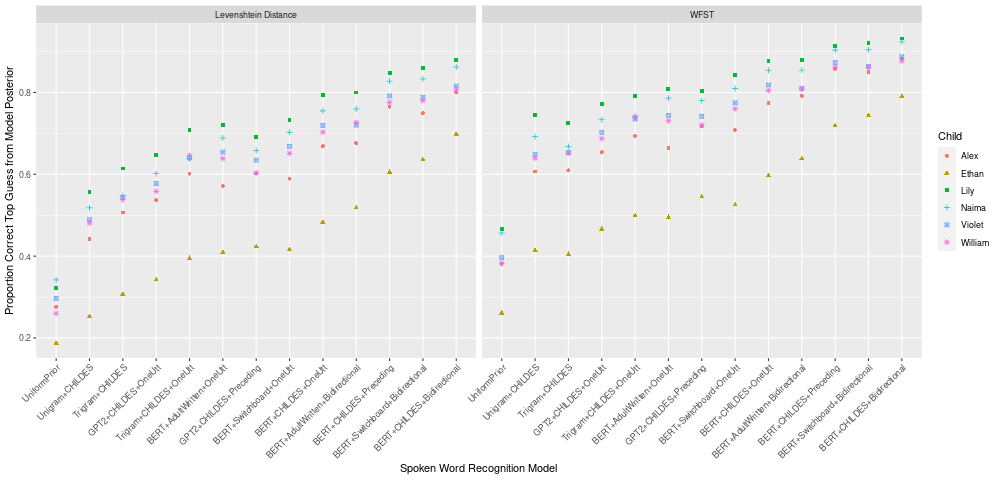

time: 638 ms (started: 2023-03-01 09:00:38 -08:00)


In [181]:
%%R -w 1000
p1 = ggplot(by_child_merged) + geom_point(aes(x=model, y=posterior_top1,
color=target_child_name, shape= target_child_name)) + facet_wrap(~ likelihood_type
) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)
) + ylab('Proportion Correct Top Guess from Model Posterior') +  labs(color='Child', shape='Child') + xlab('Spoken Word Recognition Model')
ggsave('../../output/figures/posterior_by_child.pdf', width = 10, height=5)
p1

In [174]:
%%R
avg_model_prior_performance = aggregate(prior_top1 ~ model, by_child_merged, mean)
avg_model_prior_performance = avg_model_prior_performance[order(avg_model_prior_performance$prior_top1),]

time: 18.5 ms (started: 2023-03-01 08:41:41 -08:00)


In [175]:
%%R
avg_model_prior_performance

                             model prior_top1
1                     UniformPrior 0.00000000
2                  Unigram+CHILDES 0.03383755
3                  Trigram+CHILDES 0.13574540
4              GPT2+CHILDES+OneUtt 0.16965340
6         BERT+AdultWritten+OneUtt 0.24046127
8          BERT+Switchboard+OneUtt 0.26421709
5           Trigram+CHILDES+OneUtt 0.27823283
7           GPT2+CHILDES+Preceding 0.28375357
9              BERT+CHILDES+OneUtt 0.34222605
10 BERT+AdultWritten+Bidirectional 0.36740941
11          BERT+CHILDES+Preceding 0.50401916
12  BERT+Switchboard+Bidirectional 0.52189659
13      BERT+CHILDES+Bidirectional 0.58072524
time: 59.9 ms (started: 2023-03-01 08:41:42 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [176]:
%%R
by_child_merged$prior_model = factor(by_child_merged$model, levels=avg_model_prior_performance$model)

time: 9.98 ms (started: 2023-03-01 08:41:43 -08:00)


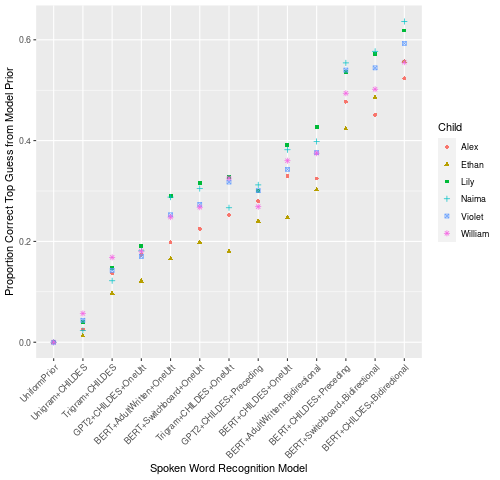

time: 1 s (started: 2023-03-01 09:00:09 -08:00)


In [180]:
%%R -w 500
p2 = ggplot(subset(by_child_merged, likelihood_type == "WFST")) + geom_point(aes(x=prior_model, y=prior_top1,
color=target_child_name, shape=target_child_name)) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)
) + ylab('Proportion Correct Top Guess from Model Prior') +  labs(color='Child', shape='Child') + xlab('Spoken Word Recognition Model')
ggsave('../../output/figures/prior_by_child.pdf', width = 5, height=5)
p2